# QA DATASET

In [1]:
!pip install bitsandbytes
!pip install -U bitsandbytes

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.0/76.0 MB 22.5 MB/s eta 0:00:00:00:0100:01


In [2]:
import pandas as pd
import numpy as np
import torch
import re
import string
import nltk
from nltk.corpus import stopwords
from tqdm import tqdm
import time
import os
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModel, AutoModelForSeq2SeqLM
from transformers import LlamaForCausalLM, GPT2LMHeadModel, GPT2Tokenizer
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from nltk.util import ngrams


In [3]:
qa_data = pd.read_csv('/kaggle/input/new-dataset/FINAL_HG_DATASET.csv')


In [4]:
qa_data

,index,question,generated_answer
0,!0001,3. What are the advantages of using a Ni foam ...,The advantages of using a Ni foam (NF) substra...
1,!0002,4. How does the hierarchical structure and com...,The hierarchical structure and composition of ...
2,!0003,4. What are the current challenges and limitat...,Current challenges and limitations of defect e...
3,!0004,5. What are the promising future research dire...,Promising future research directions in the fi...
4,!0005,4. How do the properties and performance of th...,The properties and performance of CTF films ca...
...,...,...,...
5711,!5712,What is the rate of hydrogen evolution (in µmo...,Hydrogen evolution rate for MoS?-based nanomat...
5712,!5713,How much hydrogen (in µmol) is produced per gr...,Hydrogen produced by Pt-Co alloy: Pt-Co alloys...
5713,!5714,What is the hydrogen production rate (in mL/mi...,Hydrogen production rate for MoS?/TiO? hybrid ...
5714,!5715,How much hydrogen (in µmol) is produced per gr...,Hydrogen produced by CoFe?O?-based photocataly...


In [5]:
chunk=pd.read_csv('/kaggle/input/new-dataset/cleaned_chunks (1).csv')

In [6]:
chunk

,Chunk
0,Various methods have been developed to synthes...
1,Researchers have developed a metal-free electr...
2,"MXenes, a new class of materials, are layered ..."
3,This research focuses on the design and charac...
4,Surface photocatalysts are susceptible to degr...
...,...
146,Researchers have successfully developed ordere...
147,Defect engineering and morphological engineeri...
148,"MXenes, with their unique layered structure, e..."
149,The overexploitation of fossil fuels has led t...


In [7]:
def clean_column(text):
    if isinstance(text, str):
        text = re.sub(r'\*\*|\*|!|\?', '', text).strip()
        text = re.sub(r'^\d+\.\s', '', text)
        text = re.sub(r'\s+', ' ', text)
    return text


qa_data['question'] = qa_data['question'].apply(clean_column)
qa_data['generated_answer'] = qa_data['generated_answer'].apply(clean_column)
chunk['Chunk'] = chunk['Chunk'].apply(clean_column)


In [8]:
qa_data.tail(11)

,index,question,generated_answer
5705,!5706,What is the energy consumption (in kWh) for pr...,Energy consumption for producing 100 mL of hyd...
5706,!5707,How much hydrogen (in µmol) is produced per gr...,Hydrogen produced by CoMoO-based photocatalyst...
5707,!5708,What is the hydrogen production rate (in µmol/...,Hydrogen production rate for Pt/TiO photocatal...
5708,!5709,How much hydrogen (in µmol) is produced by 1 g...,Hydrogen produced by CuO-based photocatalyst: ...
5709,!5710,What is the efficiency (%) of a NiFe alloy-bas...,Efficiency of NiFe alloy-based electrochemical...
5710,!5711,How much hydrogen (in µmol/g·h) is produced by...,Hydrogen produced by BiVO-based catalyst: BiVO...
5711,!5712,What is the rate of hydrogen evolution (in µmo...,Hydrogen evolution rate for MoS-based nanomate...
5712,!5713,How much hydrogen (in µmol) is produced per gr...,Hydrogen produced by Pt-Co alloy: Pt-Co alloys...
5713,!5714,What is the hydrogen production rate (in mL/mi...,Hydrogen production rate for MoS/TiO hybrid ca...
5714,!5715,How much hydrogen (in µmol) is produced per gr...,Hydrogen produced by CoFeO-based photocatalyst...


In [9]:
qa_data

,index,question,generated_answer
0,!0001,What are the advantages of using a Ni foam (NF...,The advantages of using a Ni foam (NF) substra...
1,!0002,How does the hierarchical structure and compos...,The hierarchical structure and composition of ...
2,!0003,What are the current challenges and limitation...,Current challenges and limitations of defect e...
3,!0004,What are the promising future research directi...,Promising future research directions in the fi...
4,!0005,How do the properties and performance of the C...,The properties and performance of CTF films ca...
...,...,...,...
5711,!5712,What is the rate of hydrogen evolution (in µmo...,Hydrogen evolution rate for MoS-based nanomate...
5712,!5713,How much hydrogen (in µmol) is produced per gr...,Hydrogen produced by Pt-Co alloy: Pt-Co alloys...
5713,!5714,What is the hydrogen production rate (in mL/mi...,Hydrogen production rate for MoS/TiO hybrid ca...
5714,!5715,How much hydrogen (in µmol) is produced per gr...,Hydrogen produced by CoFeO-based photocatalyst...


In [10]:
qa_data.dropna(inplace=True)
chunk.dropna(inplace=True)

In [11]:
qa_data=qa_data.drop(columns=['index'])

In [12]:
qa_data

,question,generated_answer
0,What are the advantages of using a Ni foam (NF...,The advantages of using a Ni foam (NF) substra...
1,How does the hierarchical structure and compos...,The hierarchical structure and composition of ...
2,What are the current challenges and limitation...,Current challenges and limitations of defect e...
3,What are the promising future research directi...,Promising future research directions in the fi...
4,How do the properties and performance of the C...,The properties and performance of CTF films ca...
...,...,...
5711,What is the rate of hydrogen evolution (in µmo...,Hydrogen evolution rate for MoS-based nanomate...
5712,How much hydrogen (in µmol) is produced per gr...,Hydrogen produced by Pt-Co alloy: Pt-Co alloys...
5713,What is the hydrogen production rate (in mL/mi...,Hydrogen production rate for MoS/TiO hybrid ca...
5714,How much hydrogen (in µmol) is produced per gr...,Hydrogen produced by CoFeO-based photocatalyst...


In [13]:
chunk

,Chunk
0,Various methods have been developed to synthes...
1,Researchers have developed a metal-free electr...
2,"MXenes, a new class of materials, are layered ..."
3,This research focuses on the design and charac...
4,Surface photocatalysts are susceptible to degr...
...,...
146,Researchers have successfully developed ordere...
147,Defect engineering and morphological engineeri...
148,"MXenes, with their unique layered structure, e..."
149,The overexploitation of fossil fuels has led t...


In [14]:
pip install --upgrade pinecone

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 421.9/421.9 kB 7.4 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


# Initializing Pinecone Index


In [ ]:
import os
from pinecone import Pinecone

pc = Pinecone(api_key=api_key)
index_name = 'hydro-question-answer'
if index_name in pc.list_indexes().names():
    pc.delete_index(index_name)
    print(f"Index '{index_name}' has been deleted.")
else:
    print(f"Index '{index_name}' does not exist.")


Exception: The official Pinecone python package has been renamed from `pinecone-client` to `pinecone`. Please remove `pinecone-client` from your project dependencies and add `pinecone` instead. See the README at https://github.com/pinecone-io/pinecone-python-client for more information on using the python SDK.

In [15]:
import os
from pinecone import Pinecone

# Set the API key directly in the code
api_key = 'df47aa2a-f42c-4446-85bc-e2a4af03f79d'

# Initialize the Pinecone client using the API key
pc = Pinecone(api_key=api_key)

In [16]:
from pinecone import ServerlessSpec

cloud = os.environ.get('PINECONE_CLOUD') or 'aws'
region = os.environ.get('PINECONE_REGION') or 'us-east-1'

spec = ServerlessSpec(cloud=cloud, region=region)

In [17]:
index_name_1 = "hydro-question-answer"
index_name_2 = "hydro-chunk"

In [18]:
if index_name_1 not in pc.list_indexes().names():

    pc.create_index(
        index_name_1,
        dimension=768,  
        metric='cosine',
        spec=spec
    )
    while not pc.describe_index(index_name_1).status['ready']:
        time.sleep(1)
index_1 = pc.Index(index_name_1)
# View index stats for the question index
print("Question Index Stats:")
print(index_1.describe_index_stats())

Question Index Stats:
{'dimension': 768,
 'index_fullness': 0.0,
 'metric': 'cosine',
 'namespaces': {'': {'vector_count': 5716}},
 'total_vector_count': 5716,
 'vector_type': 'dense'}


In [19]:
if index_name_2 not in pc.list_indexes().names():
    pc.create_index(
        index_name_2,
        dimension=768,  
        metric='cosine',
        spec=spec
    )
    while not pc.describe_index(index_name_2).status['ready']:
        time.sleep(1)
index_2 = pc.Index(index_name_2)
# View index stats for the chunk index
print("Chunk Index Stats:")
print(index_2.describe_index_stats())

Chunk Index Stats:
{'dimension': 768,
 'index_fullness': 0.0,
 'metric': 'cosine',
 'namespaces': {'': {'vector_count': 151}},
 'total_vector_count': 151,
 'vector_type': 'dense'}


# Initializing Retriever Model

In [20]:
pip install sentence-transformers

Note: you may need to restart the kernel to use updated packages.


In [21]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
retriever = SentenceTransformer("flax-sentence-embeddings/all_datasets_v3_mpnet-base", device=device)
retriever

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/9.85k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/591 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/383 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

SentenceTransformer(
  (0): Transformer({'max_seq_length': 128, 'do_lower_case': False}) with Transformer model: MPNetModel 
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False, 'include_prompt': True})
  (2): Normalize()
)

# Tokenization and Embedding Generation

In [ ]:
batch_size = 32
for i in tqdm(range(0, len(qa_data), batch_size)):
    i_end = min(i + batch_size, len(qa_data))
    batch = qa_data.iloc[i:i_end]
    combined_inputs = [
        f"Question: {row['question']} Answer: {row['generated_answer'][:200]}"  
        for _, row in batch.iterrows()
    ]
    qa_embeddings = retriever.encode(combined_inputs).tolist()
    qa_meta = batch[["question", "generated_answer"]].to_dict(orient="records")
    qa_ids = [f"qa_{idx}" for idx in range(i, i_end)]
    qa_to_upsert = list(zip(qa_ids, qa_embeddings, qa_meta))
    _ = index_1.upsert(vectors=qa_to_upsert)
print("QA Index Stats:")
print(index_1.describe_index_stats())

100%|██████████| 179/179 [02:16<00:00,  1.32it/s]


QA Index Stats:
{'dimension': 768,
 'index_fullness': 0.0,
 'metric': 'cosine',
 'namespaces': {'': {'vector_count': 5716}},
 'total_vector_count': 5716,
 'vector_type': 'dense'}


In [ ]:
batch_size = 32
for i in tqdm(range(0, len(chunk), batch_size)):
    i_end = min(i + batch_size, len(chunk))
    batch = chunk.iloc[i:i_end]
    emb = retriever.encode(batch["Chunk"].tolist()).tolist()
    meta = batch.to_dict(orient="records")
    ids = [f"{idx}" for idx in range(i, i_end)]
    to_upsert = list(zip(ids, emb, meta))
    _ = index_2.upsert(vectors=to_upsert)
print("Chunk Index Stats:")
print(index_2.describe_index_stats())


100%|██████████| 5/5 [00:05<00:00,  1.16s/it]


Chunk Index Stats:
{'dimension': 768,
 'index_fullness': 0.0,
 'metric': 'cosine',
 'namespaces': {'': {'vector_count': 151}},
 'total_vector_count': 151,
 'vector_type': 'dense'}


# Initialize Generator

# Llama 3

In [22]:
model_name = "1MK26/llama3_FT"
model = LlamaForCausalLM.from_pretrained(model_name).to("cuda")
tokenizer = AutoTokenizer.from_pretrained(model_name)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

adapter_config.json:   0%|          | 0.00/798 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.25k [00:00<?, ?B/s]

Unused kwargs: ['_load_in_4bit', '_load_in_8bit', 'quant_method']. These kwargs are not used in <class 'transformers.utils.quantization_config.BitsAndBytesConfig'>.
`low_cpu_mem_usage` was None, now default to True since model is quantized.


model.safetensors:   0%|          | 0.00/5.70G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/198 [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/168M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/50.7k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.2M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/464 [00:00<?, ?B/s]

In [23]:
def query_pinecone(query, top_k):
    xq = retriever.encode([query]).tolist()
    xc_qa = index_1.query(vector=xq, top_k=top_k, include_metadata=True)
    xc_chunk = index_2.query(vector=xq, top_k=top_k, include_metadata=True)
    return xc_qa, xc_chunk

In [26]:
def remove_questions_from_text(text):
    cleaned_text = re.sub(r'\s*\?.*$', '', text)  
    cleaned_text = re.sub(r'(How|What|Why|Where|When|Who)\s+.*\?$', '', cleaned_text)  
    cleaned_text = re.sub(r'\b(?:How|What|Why|Where|When|Who)\b.*\?', '', cleaned_text)
    return cleaned_text.strip()  
    
query1 = "what is the use of nanomaterials in hydrogen generation? "
qa_result, chunk_result = query_pinecone(query1, top_k=1)
print("QA Results:")
for match in qa_result['matches']:
    # Clean the retrieved content
    cleaned_answer = remove_questions_from_text(match['metadata'].get('generated_answer', ''))
    print(f"\nScore: {match['score']}, Metadata: {cleaned_answer}")
print("\nChunk Results:")
for match in chunk_result['matches']:
    cleaned_chunk = remove_questions_from_text(match['metadata'].get('Chunk', ''))
    print(f"\nScore: {match['score']}, Metadata: {cleaned_chunk}")


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

QA Results:

Score: 0.803814352, Metadata: Nanomaterials can help us generate hydrogen more efficiently in a number of ways, including: Catalysis: Nanomaterials can be used as catalysts for a variety of chemical reactions, including the reactions that produce hydrogen. By using nanomaterials as catalysts, we can increase the efficiency of these reactions and produce hydrogen more quickly and easily. Photocatalysis: Nanomaterials can also be used as photocatalysts, which are materials that use light to drive chemical reactions. Photocatalytic nanomaterials can be used to split water into hydrogen and oxygen, providing a clean and renewable source of hydrogen. Electrocatalysis: Nanomaterials can also be used as electrocatalysts, which are materials that use electricity to drive chemical reactions. Electrocatalytic nanomaterials can be used to produce hydrogen from water or other sources, using electricity as the energy source.In addition to these specific applications, nanomaterials can 

In [27]:
qa_context = " ".join([match['metadata']['generated_answer'] for match in qa_result['matches']])
chunk_context = " ".join([match['metadata']['Chunk'] for match in chunk_result['matches']])
combined_context = f"{qa_context} {chunk_context}"
print(combined_context)

Nanomaterials can help us generate hydrogen more efficiently in a number of ways, including: Catalysis: Nanomaterials can be used as catalysts for a variety of chemical reactions, including the reactions that produce hydrogen. By using nanomaterials as catalysts, we can increase the efficiency of these reactions and produce hydrogen more quickly and easily. Photocatalysis: Nanomaterials can also be used as photocatalysts, which are materials that use light to drive chemical reactions. Photocatalytic nanomaterials can be used to split water into hydrogen and oxygen, providing a clean and renewable source of hydrogen. Electrocatalysis: Nanomaterials can also be used as electrocatalysts, which are materials that use electricity to drive chemical reactions. Electrocatalytic nanomaterials can be used to produce hydrogen from water or other sources, using electricity as the energy source.In addition to these specific applications, nanomaterials can also be used to improve the efficiency of h

In [71]:
def generate_model_input(query_and_docs):
    return tokenizer(
        query_and_docs,
        truncation=True,
        padding="max_length",
        return_tensors="pt",
        max_length=250  
    )

def generate_model_answer(retrieved_content, query):
    query_and_docs = retrieved_content  
    model_input = generate_model_input(query_and_docs)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)  
    with torch.no_grad():  
        generated_answers_encoded = model.generate(
            input_ids=model_input["input_ids"].to(device),
            attention_mask=model_input["attention_mask"].to(device),
            min_length=50,
            max_new_tokens=250,
            num_beams=2,
            early_stopping=True,
            eos_token_id=tokenizer.eos_token_id,
            no_repeat_ngram_size=2,
            top_p=0.9,
            temperature=0.5
        )
    decoded_answers = tokenizer.batch_decode(
        generated_answers_encoded,
        skip_special_tokens=True,
        clean_up_tokenization_spaces=True
    )

    return decoded_answers

In [72]:
def generate_answer(query1):
    qa_result, chunk_result = query_pinecone(query1, top_k=2)
    qa_highest_match = max(qa_result['matches'], key=lambda x: x['score'], default=None)
    chunk_highest_match = max(chunk_result['matches'], key=lambda x: x['score'], default=None)
    if qa_highest_match and qa_highest_match['score'] >= 0.4:
        retrieved_content = qa_highest_match['metadata']['generated_answer']
    elif chunk_highest_match and chunk_highest_match['score'] >= 0.4:
        retrieved_content = chunk_highest_match['metadata']['Chunk']
    else:
        return "Answer not found"
    decoded_answers = generate_model_answer(retrieved_content, query1)
    return decoded_answers

In [68]:
query1 = "What is the rate of hydrogen production (mol/h) for g-C?N? nanomaterials in photocatalytic systems?"
generated_answer = generate_answer(query1)
print("Generated Answer:", generated_answer)

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generated Answer: ['Rate of Hydrogen Production (mol/h) for g-CN Nanomaterials in Photocatalytic Systems: g-CN nanomaterials can produce hydrogen at a rate of about 0.01\x960.05 mol/h in photocatalytic systems. This rate is influenced by factors such as the light intensity, the catalyst loading, and the presence of co-catalysts.']


# Evaluation

In [44]:
perplexity_model = GPT2LMHeadModel.from_pretrained('gpt2')
perplexity_tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
embed_model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

In [45]:
def full_evaluation(query, answers):
    def compute_embeddings(text):
        embeddings = embed_model.encode(text, convert_to_tensor=True)
        return embeddings
    metrics = {
        'cosine_similarities': [],
        'perplexities': []
    }

    for answer in answers:
        query_embedding = compute_embeddings(query)
        answer_embedding = compute_embeddings(answer)
        similarity_score = cosine_similarity(query_embedding.cpu().numpy().reshape(1, -1),
                                             answer_embedding.cpu().numpy().reshape(1, -1))[0][0]
        inputs = perplexity_tokenizer(answer, return_tensors='pt')
        with torch.no_grad():
            loss = perplexity_model(**inputs, labels=inputs['input_ids'])[0]
        perplexity_score = torch.exp(loss).item()
        metrics['cosine_similarities'].append(similarity_score)
        metrics['perplexities'].append(perplexity_score)

    for i in range(len(answers)):
        print(f"\nEvaluation Metrics for Answer :")
        print(f"Cosine Similarity: {metrics['cosine_similarities'][i]:.4f}")
        print(f"Perplexity: {metrics['perplexities'][i]:.4f}")

    return metrics



## Testing

In [73]:
query1 = "What is hydrogen generation, and why is it important?"
generated_answer = generate_answer(query1)
print("Generated Answer:", generated_answer)
evaluation_result = full_evaluation(query1, generated_answer)

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generated Answer: ['What is Hydrogen GenerationHydrogen generation is the process of producing hydrogen gas (H2) from various sources. Hydrogen gas can be generated through several methods, including: Steam reforming of hydrocarbons (e.g., natural gas, coal) Water electrolysis Coal gasification Biomass gasificationImportance of Hydrogen Generation:Hydrogen gas plays a crucial role in various industries and applications due to its unique properties: Clean and sustainable fuel: Hydrogen burns cleanly without producing carbon emissions, making it an environmentally friendly alternative to fossil fuels. High energy density: Hydrogen has a high energy content per unit mass, making it a promising candidate for fuel cells and other energy storage systems. Versatile feedstock: Hydrogen can be used as a feedstock for various industrial processes, such as ammonia production and oil refining. Potential decarbonization solution: Hydrogen can contribute to decarbonizing sectors like transportation,

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Evaluation Metrics for Answer :
Cosine Similarity: 0.8011
Perplexity: 13.3478


In [74]:
def load_queries_from_csv(csv_file_path, query_column):
    df = pd.read_csv(csv_file_path)
    queries = df[query_column].tolist()  
    return queries

def save_evaluation_results(output_file_path, results):
    df = pd.DataFrame(results)
    df.to_csv(output_file_path, index=False)
    print(f"Results saved to {output_file_path}")


csv_file_path = '/kaggle/input/hg-testing-llama/Cleaned_HG_Questions_Testing.csv'
query_column = 'Question'
queries = load_queries_from_csv(csv_file_path, query_column)
evaluation_results = []
for query1 in queries:
    generated_answer = generate_answer(query1)
    evaluation_result = full_evaluation(query1, generated_answer)
    print(f"Query: {query1}")
    print(f"Generated Answer: {generated_answer}")
    print(f"Evaluation Result: {evaluation_result}\n")
    evaluation_results.append({
        'Query': query1,
        'Generated Answer': generated_answer,
        'Evaluation': evaluation_result
    })


output_file_path = '/kaggle/working/Llama_evaluation_results.csv'
save_evaluation_results(output_file_path, evaluation_results)

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Evaluation Metrics for Answer :
Cosine Similarity: 0.8011
Perplexity: 13.3478
Query: What is hydrogen generation, and why is it important?
Generated Answer: ['What is Hydrogen GenerationHydrogen generation is the process of producing hydrogen gas (H2) from various sources. Hydrogen gas can be generated through several methods, including: Steam reforming of hydrocarbons (e.g., natural gas, coal) Water electrolysis Coal gasification Biomass gasificationImportance of Hydrogen Generation:Hydrogen gas plays a crucial role in various industries and applications due to its unique properties: Clean and sustainable fuel: Hydrogen burns cleanly without producing carbon emissions, making it an environmentally friendly alternative to fossil fuels. High energy density: Hydrogen has a high energy content per unit mass, making it a promising candidate for fuel cells and other energy storage systems. Versatile feedstock: Hydrogen can be used as a feedstock for various industrial processes, such as am

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Evaluation Metrics for Answer :
Cosine Similarity: 0.7830
Perplexity: 11.5836
Query: What is water splitting, and how does it produce hydrogen?
Generated Answer: ['What is Water SplittingWater splitting is a chemical process that breaks down water molecules (H2O) into hydrogen (H2) and oxygen (O2) using an external energy source. The general equation for water splitting is:```2H2O 2H2 + O2```How Water Splitting Produces Hydrogen:Water splitting can be achieved through various methods, including: Electrolysis: This process uses an electrical current to drive the water splitting reaction. Water is placed in an electrolytic cell, and an electric current is passed through it. The current causes water molecules to split into hydrogen and oxygen gases, which are then collected separately. Photoelectrolysis: This method combines electrolysis with photocatalysis. A semiconductor material is used as the anode in the electrolytic cell. When light shines on the semiconductor, it generates an ele

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Evaluation Metrics for Answer :
Cosine Similarity: 0.6987
Perplexity: 15.3103
Query: What are 2D nanomaterials?
Generated Answer: ['Two-Dimensional (2D) Nanomaterials:Two-dimensional (2D) nanomaterials are atomically thin materials with a thickness of a single atom or a few atomic layers. They possess unique properties and applications due to their reduced dimensionality and quantum confinement effects.Key Characteristics: Atomically Thin: 2D nanomaterials have a thickness of one or a few atomic layers, typically ranging from 0.3 to 10 nanometers. High Surface-to-Volume Ratio: The large surface area relative to their volume makes 2D nanomaterials highly reactive and suitable for surface-related applications. Quantum Confinement: Electrons in 2D nanomaterials are confined in two dimensions, leading to unique electronic and optical properties. Anisotropy: 2D nanomaterials often exhibit anisotropic properties, meaning their properties vary depending on the direction of measurement.Exampl

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Evaluation Metrics for Answer :
Cosine Similarity: 0.7431
Perplexity: 15.5878
Query: Why are 2D materials considered for hydrogen generation?
Generated Answer: ['2D materials are considered for hydrogen generation due to their unique properties that make them promising candidates for efficient and sustainable hydrogen production: High surface area: 2D materials have an extremely high surface area-to-volume ratio, which provides a large number of active sites for catalytic reactions. This high surface area is crucial for efficient hydrogen generation processes, such as water splitting and photocatalytic hydrogen production. Tunable electronic properties: The electronic properties of 2D materials can be precisely controlled by modifying their composition, doping, or stacking. This tunability allows researchers to optimize the materials for specific hydrogen generation applications and improve their efficiency. Excellent charge transport: 2D materials exhibit excellent charge transport p

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Evaluation Metrics for Answer :
Cosine Similarity: 0.7826
Perplexity: 23.7643
Query: What role do catalysts play in water splitting?
Generated Answer: ['Catalysts play a crucial role in water splitting by reducing the activation energy required for the reaction to occur. Water splitting is a thermodynamically uphill reaction, meaning that it requires an input of energy to proceed. Catalysts help to lower the energy barrier and make the reaction more efficient.In water splitting, catalysts are typically used to facilitate the following two half-reactions: Hydrogen evolution reaction (HER): 2H+ + 2e- H2 Oxygen evolution reaction (OER): 2H2O O2 + 4H+ + 4e-Both the HER and OER are kinetically sluggish reactions, meaning that they occur slowly without a catalyst. Catalysts provide active sites where the reactants can adsorb and undergo the necessary transformations to produce hydrogen and oxygen.Effective catalysts for water splitting should possess the following properties: High activity:

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Evaluation Metrics for Answer :
Cosine Similarity: 0.6326
Perplexity: 13.2725
Query: What are some common 2D nanomaterials used in hydrogen production?
Generated Answer: ['Common 2D nanomaterials used in hydrogen production include: Graphene: Graphene is a single layer of carbon atoms arranged in a hexagonal lattice. It has a high surface area and excellent electrical conductivity, making it a promising material for both hydrogen evolution and oxygen evolution reactions. Transition metal dichalcogenides (TMDs): TMDs are a class of 2D materials with the general formula MX2, where M is a transition metal (e.g., Mo, W, Ti) and X is a chalcogen (e.g., S, Se, Te). TMDs have tunable electronic properties and can be used as both HER and OER catalysts. Black phosphorus: Black phosphorus is a 2D material with a puckered honeycomb structure. It has a high surface area and excellent charge transport properties, making it a promising candidate for HER. Phosphorene: Phosphorene is a single layer o

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Evaluation Metrics for Answer :
Cosine Similarity: 0.7608
Perplexity: 12.1234
Query: How does the structure of 2D nanomaterials affect their catalytic properties?
Generated Answer: ['The structure of 2D nanomaterials significantly affects their catalytic properties in several ways: Surface area: The high surface area of 2D nanomaterials provides a large number of active sites for catalytic reactions. The specific surface area, which is the surface area per unit mass, is an important factor in determining the catalytic activity of a material. Edge sites: The edges of 2D nanomaterials often have a different electronic structure and coordination environment compared to the basal planes. These edge sites can be particularly active for certain catalytic reactions. Defect sites: Defects in the crystal structure of 2D nanomaterials can create active sites for catalytic reactions. These defects can be introduced intentionally through chemical or physical treatments to enhance the catalytic ac

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Evaluation Metrics for Answer :
Cosine Similarity: 0.8082
Perplexity: 12.0359
Query: What is the principle of photocatalysis in hydrogen generation?
Generated Answer: ['Photocatalysis is a process that uses light energy to drive a chemical reaction. In the context of hydrogen generation, photocatalysis refers to the use of a photocatalyst material to split water into hydrogen and oxygen using light energy.The principle of photocatalysis in hydrogen generation involves the following steps:1. Light absorption: The photocatalyst material absorbs light energy, typically in the ultraviolet or visible spectrum. This energy excites electrons in the photocatalyst, creating electron-hole pairs.2. Charge separation: The electron-hole pairs are separated and migrate to different sites on the photocatalyst surface. Electrons typically move to the conduction band, while holes move to the valence band.3. Redox reactions: The electrons and holes react with water molecules on the photocatalyst surfac

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Evaluation Metrics for Answer :
Cosine Similarity: 0.6613
Perplexity: 15.9362
Query: How does the bandgap of 2D materials influence their effectiveness in water splitting?
Generated Answer: ['The bandgap of 2D materials significantly influences their effectiveness in water splitting due to its impact on the absorption of light energy and the redox potentials of the photogenerated charge carriers.Light absorption: The bandgap determines the wavelength of light that a 2D material can absorb. For water splitting, the ideal bandgap is around 1.23 eV, which corresponds to the energy required to split water into hydrogen and oxygen. 2D materials with a bandgap close to this value can efficiently absorb visible light, which is abundant and cost-effective.Redox potentials: The conduction and valence band edges of a 2D material determine the redox potentials of the photogenerated electrons and holes. For efficient water splitting, the conduction band edge should be more negative than the reduc

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Evaluation Metrics for Answer :
Cosine Similarity: 0.7984
Perplexity: 6.2541
Query: What are the potential environmental benefits of hydrogen as an energy source?
Generated Answer: ['Advantages of hydrogen as a fuel source:1. High energy content: Hydrogen has a high energy content per unit mass, making it a very efficient fuel source.2. Clean burning: Hydrogen burns cleanly, producing only water vapor as a byproduct. This makes it an environmentally friendly fuel source.3. Renewable: Hydrogen can be produced from renewable sources, such as solar and wind energy. This makes it a sustainable fuel source.4. Versatile: Hydrogen can be used in a variety of applications, including fuel cells, internal combustion engines, and gas turbines.5. Abundant: Hydrogen is the most abundant element in the universe. This makes it a plentiful fuel source.6. Cost-effective: The cost of producing hydrogen is expected to decrease as research and development efforts continue.']
Evaluation Result: {'cosine_s

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Evaluation Metrics for Answer :
Cosine Similarity: 0.7961
Perplexity: 15.2145
Query: How do 2D materials enhance the efficiency of photocatalytic water splitting?
Generated Answer: ['2D materials can enhance the efficiency of photocatalytic water splitting in several ways: High surface area: 2D materials have a large surface area relative to their volume, which provides more active sites for the photocatalytic reactions to take place. This increased surface area allows for more efficient absorption of light and generation of charge carriers. Tunable electronic properties: The electronic properties of 2D materials can be precisely controlled by modifying their composition, doping, or stacking. By tailoring the bandgap and band edge positions, 2D materials can be optimized to efficiently absorb light and drive the redox reactions involved in water splitting. Efficient charge separation and transport: 2D materials often exhibit excellent charge separation and transport properties due to 

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Evaluation Metrics for Answer :
Cosine Similarity: 0.8438
Perplexity: 11.7031
Query: What are the advantages of using graphene-based materials for hydrogen generation?
Generated Answer: ['Graphene-based materials offer several advantages for hydrogen generation: High surface area: Graphene has an extremely high surface area, providing a large number of active sites for catalytic reactions. This enhances the efficiency of hydrogen production processes, such as water splitting and photocatalytic hydrogen generation. Excellent electrical conductivity: Graphene is a highly conductive material, which facilitates the transfer of electrons during hydrogen generation reactions. This improved charge transport enhances the overall efficiency of the process. Tunable electronic properties: The electronic properties of graphene can be precisely controlled by modifying its structure, doping, or functionalization. This tunability allows researchers to optimize graphene-based materials for specific h

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Evaluation Metrics for Answer :
Cosine Similarity: 0.7261
Perplexity: 18.8144
Query: How does the surface area of 2D nanomaterials impact their catalytic performance?
Generated Answer: ["The surface area of 2D nanomaterials plays a crucial role in their catalytic activity due to the following factors: Increased Active Sites: A larger surface area provides more active sites for catalytic reactions to take place. Each active site can serve as a reaction center where reactants can adsorb and undergo chemical transformations. Enhanced Adsorption: The increased surface area allows for better adsorption of reactants onto the nanomaterial's surface. Stronger adsorption promotes efficient interaction between the reactants and the catalyst, facilitating the activation of reactants and the initiation of catalytic reactions. Improved Mass Transport: A larger surface area reduces the diffusion limitations for reactants and products. This improved mass transport ensures a steady supply of reactant

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Evaluation Metrics for Answer :
Cosine Similarity: 0.6679
Perplexity: 12.4041
Query: What are the challenges associated with the stability of 2D nanomaterials in water splitting?
Generated Answer: ['Chemical stability plays a crucial role in the long-term performance of 2D nanomaterials in water splitting: Degradation mechanisms: 2D nanomaterials can be susceptible to various degradation mechanisms during water splitting, including photocorrosion, chemical etching, and oxidation. These degradation processes can lead to the loss of active sites, reduced surface area, and diminished photocatalytic activity over time. Stability under reaction conditions: The chemical stability of 2D nanomaterials under water splitting conditions is critical for their long-term performance. Factors such as pH, temperature, and the presence of corrosive species can influence the stability of these materials. Stable 2D nanomaterials can withstand these harsh conditions and maintain their activity over exten

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Evaluation Metrics for Answer :
Cosine Similarity: 0.8582
Perplexity: 18.8607
Query: How can doping with different elements improve the properties of 2D nanomaterials for hydrogen production?
Generated Answer: ["Doping 2D nanomaterials with different elements can significantly improve their properties for hydrogen production in several ways: Electronic structure modification: Doping introduces additional electron donors or acceptors into the 2D nanomaterial, altering its electronic structure and bandgap. This modification can enhance the absorption of light energy, improve charge carrier separation, and optimize the redox potentials for hydrogen evolution or oxygen evolution reactions. Defect engineering: Doping can create defects or vacancies in the 2D nanomaterial's crystal structure. These defects can act as active sites for catalytic reactions, providing additional pathways for hydrogen production. Enhanced conductivity: Doping can improve the electrical conductivity of 2D nanomat

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Evaluation Metrics for Answer :
Cosine Similarity: 0.6419
Perplexity: 13.5905
Query: What techniques are used to synthesize 2D nanomaterials for water splitting applications?
Generated Answer: ['Various techniques are employed to synthesize 2D nanomaterials for water splitting applications, each with its own advantages and limitations. Here are some commonly used techniques: Exfoliation: This method involves the separation of individual 2D layers from bulk materials. It can be achieved through mechanical exfoliation (e.g., scotch tape method), liquid-phase exfoliation (using solvents or surfactants), or electrochemical exfoliation. Exfoliation techniques offer high-quality 2D nanomaterials with well-defined structures. Chemical vapor deposition (CVD): CVD involves the deposition of 2D nanomaterials on a substrate surface from gaseous precursors. This technique allows for precise control over the growth parameters, enabling the synthesis of high-quality and large-area 2D nanomaterials.

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Evaluation Metrics for Answer :
Cosine Similarity: 0.7365
Perplexity: 14.4412
Query: How do 2D nanomaterials interact with light during the photocatalytic process?
Generated Answer: ['2D nanomaterials interact with light during the photocatalytic process in several important ways: Light absorption: 2D nanomaterials have unique optical properties that allow them to efficiently absorb light energy. The bandgap of a 2D nanomaterial determines the wavelength of light it can absorb. By tuning the bandgap through compositional engineering or heterostructure formation, researchers can optimize the light absorption of 2D nanomaterials for specific regions of the solar spectrum. Charge generation: When a photon of light is absorbed by a 2D nanomaterial, it can excite an electron from the valence band to the conduction band, creating an electron-hole pair. These charge carriers are then available to participate in the photocatalytic reactions. Charge separation: The separation of photogenerated

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Evaluation Metrics for Answer :
Cosine Similarity: 0.7919
Perplexity: 18.2388
Query: What are the main reaction mechanisms involved in photocatalytic water splitting?
Generated Answer: ['The main reaction mechanisms involved in photocatalytic water splitting are: Light absorption: The first step is the absorption of light energy by the photocatalyst, which generates electron-hole pairs. Charge separation: The electron-hole pairs must be separated to prevent recombination and allow them to participate in the redox reactions. This separation can be facilitated by built-in electric fields or the presence of cocatalysts. Water oxidation: The holes (positive charges) are used to oxidize water molecules, producing oxygen and protons (H+). This reaction typically occurs on the surface of the photocatalyst. Hydrogen evolution: The electrons (negative charges) are used to reduce protons, producing hydrogen gas. This reaction can also occur on the surface of the photocatalyst or on a separate c

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Evaluation Metrics for Answer :
Cosine Similarity: 0.8176
Perplexity: 19.0037
Query: How can surface modifications of 2D nanomaterials improve their photocatalytic activity?
Generated Answer: ["Surface modifications of 2D nanomaterials can significantly improve their photocatalytic activity by: Enhancing light absorption: Surface modifications can introduce new optical properties or alter the bandgap of the 2D nanomaterial, enabling it to absorb a broader range of light wavelengths. This can lead to increased light harvesting and improved photocatalytic efficiency. Promoting charge separation: Surface modifications can create defects or introduce heterojunctions that facilitate the separation of photogenerated electron-hole pairs. By reducing recombination losses, more charge carriers are available for participating in the photocatalytic reactions. Increasing surface area: Surface modifications, such as etching or the formation of nanostructures, can increase the surface area of the 2

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Evaluation Metrics for Answer :
Cosine Similarity: 0.7773
Perplexity: 20.3783
Query: How do the electronic properties of 2D nanomaterials influence their hydrogen production efficiency?
Generated Answer: ['The electronic properties of 2D nanomaterials significantly influence their hydrogen production efficiency in several ways: Bandgap: The bandgap of a 2D nanomaterial determines the wavelength of light it can absorb. For efficient photocatalytic hydrogen production, the bandgap should be suitable to absorb a significant portion of the solar spectrum, typically in the visible or near-infrared region. Work function: The work function of a 2D nanomaterial affects the ability of photogenerated electrons to transfer to other materials or molecules. A lower work function facilitates the transfer of electrons to hydrogen ions, promoting the hydrogen evolution reaction. Density of states: The density of states (DOS) near the band edges determines the availability of charge carriers foring in

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Evaluation Metrics for Answer :
Cosine Similarity: 0.7332
Perplexity: 18.5989
Query: How can combining different 2D materials create synergies in photocatalytic activity?
Generated Answer: ['Combining different 2D materials can create synergies in photocatalytic activity by: Tailoring band alignment: By combining 2D materials with different bandgaps, it is possible to create type II heterostructures with a staggered band alignment. This alignment facilitates efficient charge separation, where photogenerated electrons and holes are spatially separated to different 2D materials, reducing recombination losses. Enhancing light absorption: Combining 2D materials with complementary light absorption properties can extend the overall absorption range of the photocatalyst. This can be achieved by combining materials with different bandgaps or by creating plasmonic effects that enhance light absorption in specific regions of the spectrum. Promoting charge transfer: The interface between differe

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Evaluation Metrics for Answer :
Cosine Similarity: 0.7887
Perplexity: 10.8851
Query: What are the effects of varying the thickness of 2D nanomaterials on their catalytic properties?
Generated Answer: ["Varying the thickness of 2D nanomaterials can significantly affect their catalytic properties, including: Surface area: The thickness of a 2D nanomaterial directly influences its surface area. Thinner 2D materials have a larger surface area per unit mass, providing more active sites for catalytic reactions. Electronic properties: The thickness of a 2D nanomaterial can affect its electronic structure, including its bandgap and density of states. This can influence the material's ability to absorb light and generate charge carriers, which are essential for photocatalytic reactions. Charge transport: The thickness of a 2D nanomaterial can affect the transport of charge carriers within the material. Thinner 2D materials typically have reduced charge carrier scattering, leading to improved c

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Evaluation Metrics for Answer :
Cosine Similarity: 0.8220
Perplexity: 15.5217
Query: What role does temperature play in the efficiency of hydrogen production via water splitting?
Generated Answer: ['Temperature plays a crucial role in the efficiency of hydrogen production via water splitting in several ways: Reaction kinetics: The rate of the water splitting reactions increases with increasing temperature. Higher temperatures provide more energy to the reactants, allowing them to overcome the activation energy barrier and react more quickly. Catalyst activity: The activity of catalysts for water splitting is often temperature-dependent. Some catalysts exhibit optimal activity at specific temperature ranges, and their performance may decrease or increase as the temperature deviates from these ranges. Thermodynamics: The thermodynamics of water splitting also depend on temperature. At higher temperatures, the equilibrium shifts towards the production of hydrogen and oxygen, making the r

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Evaluation Metrics for Answer :
Cosine Similarity: 0.7011
Perplexity: 13.2934
Query: How can the stability of 2D nanomaterials be assessed during long-term water splitting experiments?
Generated Answer: ["Assessing the stability of 2D nanomaterials during long-term water splitting experiments is crucial to evaluate their potential for practical applications. Here's how it can be done: Structural characterization: Techniques such as X-ray diffraction (XRD), transmission electron microscopy (TEM), and atomic force microscopy (AFM) can be used to analyze the structural changes and integrity of 2D nanomaterials after prolonged water splitting. These techniques provide information about the preservation of the crystal structure, morphology, and surface properties. Electrochemical characterization: Electrochemical techniques, such as cyclic voltammetry and electrochemical impedance spectroscopy, can be employed to monitor the electrocatalytic activity and stability of 2D nanomaterials over 

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Evaluation Metrics for Answer :
Cosine Similarity: 0.6763
Perplexity: 10.7993
Query: How can 2D nanomaterials contribute to the development of sustainable energy solutions?
Generated Answer: ['2D nanomaterials can contribute to the development of sustainable energy solutions in several ways: Hydrogen production: 2D nanomaterials have shown great promise as efficient and durable catalysts for hydrogen production through water splitting. Their unique properties, such as high surface area and tunable electronic structure, enable them to facilitate the electrochemical reactions involved in water splitting, leading to improved hydrogen production efficiency. Solar energy conversion: 2D nanomaterials can be used as active materials in solar cells to convert sunlight into electricity. Their ability to absorb a broad range of light wavelengths, coupled with their high charge carrier mobility, makes them promising candidates for enhancing the efficiency of photovoltaic devices. Energy storage:

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Evaluation Metrics for Answer :
Cosine Similarity: 0.7371
Perplexity: 10.1181
Query: What are the economic implications of using 2D materials in hydrogen generation technologies?
Generated Answer: ['Potential of emerging 2D materials for large-scale hydrogen production: High efficiency: 2D materials have the potential to achieve high efficiency for hydrogen generation due to their unique properties, such as their large surface area, high light absorption, and tunable bandgap. Low cost: Some 2D materials are abundant and inexpensive to produce, which makes them a cost-effective option for large-scale hydrogen production. Scalability: 2D materials can be synthesized using scalable methods, such as chemical vapor deposition and liquid-phase exfoliation, which allows for the production of large quantities of materials for large-scale applications. Integration with other technologies: 2D materials can be integrated with other technologies, such as photovoltaics and water splitting systems,

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Evaluation Metrics for Answer :
Cosine Similarity: 0.7144
Perplexity: 10.7759
Query: How do 2D nanomaterials compare to traditional catalysts in terms of performance and cost?
Generated Answer: ['2D nanomaterials offer several advantages over traditional catalysts in terms of performance and cost:Performance: High surface area: 2D nanomaterials have a very high surface area-to-volume ratio, which provides a large number of active sites for catalytic reactions. This high surface area can lead to improved catalytic activity and efficiency. Tunable properties: The electronic and structural properties of 2D nanomaterials can be precisely controlled through various synthesis methods and post-treatment techniques. This tunability allows researchers to optimize the properties of 2D nanomaterials for specific catalytic reactions, leading to enhanced performance. Synergistic effects: 2D nanomaterials can be combined with other materials, such as metals or semiconductors, to form heterostructur

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Evaluation Metrics for Answer :
Cosine Similarity: 0.7306
Perplexity: 8.1973
Query: What regulatory challenges exist for implementing hydrogen production using 2D nanomaterials?
Generated Answer: ['The major challenges in scaling up the production of hydrogen through 2D nanomaterial-based water splitting include: Cost: 2D nanomaterials are often expensive to produce, which can make it difficult to scale up production to a commercial level. Stability: 2D nanomaterials can be unstable in the harsh conditions required for water splitting, such as high temperatures and pH extremes. This can lead to a decrease in efficiency and a shorter lifespan for the water splitting device. Scalability: It can be difficult to scale up the production of 2D nanomaterials to the large quantities that would be needed for commercial applications. This is because the synthesis of 2D nanomaterials is often a complex and time-consuming process. Integration: Integrating 2D nanomaterials into water splitting dev

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Evaluation Metrics for Answer :
Cosine Similarity: 0.6355
Perplexity: 13.9653
Query: How can public perception of hydrogen energy influence its adoption?
Generated Answer: ['Key Technological Barriers for Widespread Hydrogen Adoption: Hydrogen Production Costs: Currently, hydrogen production costs are higher compared to fossil fuels, particularly when produced from renewable energy sources. Reducing production costs through technological advancements and economies of scale is crucial. Hydrogen Storage and Transportation: Developing safe, efficient, and cost-effective methods for storing and transporting large quantities of hydrogen remains a challenge. Fuel Cell Efficiency and Durability: Improving the efficiency and durability of hydrogen fuel cells, especially in heavy-duty applications, is essential for widespread adoption in transportation. Hydrogen Infrastructure: Establishing a comprehensive hydrogen infrastructure, including production facilities, distribution networks, and ref

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Evaluation Metrics for Answer :
Cosine Similarity: 0.8036
Perplexity: 10.6160
Query: What role do government policies play in advancing research on hydrogen generation technologies?
Generated Answer: ['Government policies play a crucial role in advancing research on hydrogen generation technologies in several ways: Funding and research grants: Governments can provide funding and research grants to universities, research institutions, and companies to support basic and applied research on hydrogen generation technologies. This funding can enable researchers to explore novel approaches, develop new materials and catalysts, and optimize existing technologies. Tax incentives and subsidies: Governments can implement tax incentives and subsidies to encourage private sector investment in hydrogen generation research and development. These incentives can help reduce the financial risks associated with research and development and make it more attractive for companies to invest in this field. 

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Evaluation Metrics for Answer :
Cosine Similarity: 0.8075
Perplexity: 16.8289
Query: How can life cycle assessments be used to evaluate the sustainability of hydrogen production methods?
Generated Answer: ['Life cycle assessments (LCAs) play a crucial role in evaluating the sustainability of hydrogen production methods by considering the environmental impacts throughout the entire life cycle of hydrogen production, from resource extraction to end-use. LCAs provide a comprehensive understanding of the environmental footprint of different hydrogen production pathways and help identify areas for improvement.Key steps involved in LCA for hydrogen production:1. Define the goal and scope: Clearly define the purpose and boundaries of the LCA, including the specific hydrogen production method being evaluated and the life cycle stages to be considered.2. Inventory analysis: Identify and quantify all inputs and outputs associated with the hydrogen production process, including raw materials, en

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Evaluation Metrics for Answer :
Cosine Similarity: 0.7779
Perplexity: 9.7356
Query: What are the potential risks associated with the large-scale use of nanomaterials in hydrogen production?
Generated Answer: ["The large-scale use of nanomaterials in hydrogen production poses several potential risks that need to be carefully considered and managed: Environmental risks: Engineered nanomaterials have unique physicochemical properties that may differ from their bulk counterparts, and their potential environmental impacts are not fully understood. Concerns exist about the release of nanomaterials into the environment during production, use, and disposal, and their potential effects on ecosystems and human health. Health and safety risks: Nanomaterials can interact with biological systems in complex ways, and their potential health effects need to be thoroughly evaluated. Inhalation, ingestion, or dermal exposure to nanomaterials may lead to adverse health effects, including inflammation, o

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Evaluation Metrics for Answer :
Cosine Similarity: 0.7438
Perplexity: 10.2152
Query: How do 2D nanomaterials fit into the broader context of renewable energy technologies?
Generated Answer: ['2D nanomaterials play a crucial role in the broader context of renewable energy technologies due to their unique properties and potential applications: Solar energy: 2D nanomaterials, such as graphene and transition metal dichalcogenides (TMDs), have exceptional light absorption and charge transport properties, making them promising materials for photovoltaics and solar cells. They can enhance the efficiency of solar energy conversion and contribute to the development of next-generation solar technologies. Wind energy: 2D nanomaterials can be used to develop lightweight and durable wind turbine blades. Their high strength-to-weight ratio and electrical conductivity can improve the efficiency and reliability of wind turbines, harnessing wind energy more effectively. Bioenergy: 2D nanomaterials can

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Evaluation Metrics for Answer :
Cosine Similarity: 0.8128
Perplexity: 12.5205
Query: How can machine learning be applied to optimize the design of 2D nanomaterials for hydrogen generation?
Generated Answer: ['Machine learning (ML) can be applied to the discovery and optimization of 2D materials for hydrogen generation in several ways:Discovery of new 2D materials: ML models can be trained on a database of known 2D materials and their properties to identify promising candidates for hydrogen generation. These models can be used to screen large chemical space and predict the properties of new 2D materials that have not yet been synthesized. By focusing on specific properties that are important for hydrogen generation, such as bandgap, light absorption, and catalytic activity, ML can accelerate the discovery of new 2D materials with enhanced performance.Optimization of 2D materials: ML models can be used to optimize the properties of existing 2D materials for hydrogen generation. By train

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Evaluation Metrics for Answer :
Cosine Similarity: 0.6985
Perplexity: 17.4352
Query: How does collaboration between academia and industry facilitate advancements in hydrogen technologies?
Generated Answer: ['Role of International Collaboration and Public-Private Partnerships in Advancing Hydrogen Research:International collaboration and public-private partnerships play crucial roles in accelerating hydrogen research and development:International Collaboration: Sharing of Knowledge and Expertise: Collaboration enables researchers from different countries to share their knowledge, expertise, and best practices, fostering innovation and cross-pollination of ideas. Access to Specialized Facilities: International partnerships provide access to specialized research facilities and infrastructure that may not be available in individual countries. Global Standardization: Collaboration facilitates the development of global standards and protocols for hydrogen production, storage, and utilizatio

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Evaluation Metrics for Answer :
Cosine Similarity: 0.7275
Perplexity: 9.1886
Query: What are the main funding sources for research on hydrogen generation and nanomaterials?
Generated Answer: ['The main funding sources for research on hydrogen generation and nanomaterials include: Government agencies: National and international government agencies, such as the U.S. Department of Energy, the European Union Horizon 2020 program, and the Japan Science and Technology Agency, provide significant funding for research in these areas. Governments recognize the importance of hydrogen as a clean energy carrier and the potential of nanomaterials to advance hydrogen generation technologies. Private companies: Companies involved in the energy, automotive, and chemical industries often invest in research on hydrogen generation and nanomaterials to develop new technologies and products. These companies have a vested interest in advancing hydrogen technologies for commercial applications. Venture capi

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Evaluation Metrics for Answer :
Cosine Similarity: 0.6866
Perplexity: 15.8049
Query: How can data sharing and open science contribute to faster advancements in this field?
Generated Answer: ["Data sharing and open science can contribute to faster advancements in hydrogen generation and nanomaterials research in several ways: Accelerated knowledge dissemination: Open sharing of research data and results allows scientists to access and build upon each other's work more quickly, leading to accelerated knowledge dissemination and the identification of new research directions. Improved reproducibility and transparency: Data sharing promotes transparency and reproducibility in research. When data is openly available, other researchers can independently verify and reproduce results, increasing the credibility and reliability of scientific findings. Increased collaboration and innovation: Open data sharing facilitates collaboration among researchers across different institutions and countries

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Evaluation Metrics for Answer :
Cosine Similarity: 0.8569
Perplexity: 11.4238
Query: What role do conferences and workshops play in the development of hydrogen generation technologies?
Generated Answer: ['Conferences and workshops play a vital role in the development of hydrogen generation technologies by: Facilitating knowledge exchange: Conferences and workshops bring together researchers, industry experts, and policymakers to share their latest findings, discuss ongoing challenges, and explore future research directions. This exchange of knowledge and ideas helps accelerate the development of new technologies and approaches. Promoting collaboration: Conferences and workshops provide a platform for researchers and industry representatives to connect and establish collaborations. These collaborations can lead to joint research projects, technology transfer, and the development of new partnerships. Identifying research gaps and priorities: Through discussions and presentations, confer

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Evaluation Metrics for Answer :
Cosine Similarity: 0.6848
Perplexity: 14.8786
Query: How can the findings from recent studies on 2D nanomaterials be translated into practical applications?
Generated Answer: ['Translating the findings from recent studies on 2D nanomaterials into practical applications involves several key steps:1. Proof-of-concept and optimization: Once promising 2D nanomaterials are identified through research, their performance and stability need to be thoroughly evaluated under realistic conditions. This may involve optimizing synthesis methods, device designs, and operating parameters to achieve the desired efficiency and durability.2. Scale-up and manufacturing: For practical applications, it is crucial to develop cost-effective and scalable methods for producing high-quality 2D nanomaterials in large quantities. This may require adapting existing manufacturing techniques or developing new processes specifically tailored for 2D materials.3. Integration into device

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Evaluation Metrics for Answer :
Cosine Similarity: 0.8221
Perplexity: 15.5108
Query: What are the best practices for conducting experiments on water splitting with 2D nanomaterials?
Generated Answer: ["Best practices for conducting experiments on water splitting with 2D nanomaterials include:1. Material characterization: Thoroughly characterize the 2D nanomaterials used, including their composition, structure, morphology, and optical and electronic properties. This provides a baseline for understanding the material's behavior and correlating it with water splitting performance.2. Experimental setup optimization: Optimize the experimental setup to ensure accurate and reproducible results. This involves selecting appropriate light sources, electrochemical cells, and measurement techniques. Calibrating equipment and using reference materials are crucial for reliable data acquisition.3. Control experiments: Include appropriate control experiments to rule out the influence of external fact

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Evaluation Metrics for Answer :
Cosine Similarity: 0.7269
Perplexity: 12.7450
Query: How do ethical considerations influence research and commercialization in hydrogen production technologies?
Generated Answer: ['Ethical considerations play a significant role in research and commercialization of hydrogen production technologies, particularly those involving 2D nanomaterials:1. Environmental impact: The environmental impact of hydrogen production technologies needs to be carefully assessed, considering the full life cycle of the technology, fromextraction to waste disposal. Researchers and companies should prioritize sustainable and environmentally friendly approaches to minimize the ecological footprint.2. Health and safety: The potential health and safety risks associated with 2D nanomaterials must be thoroughly evaluated. Researchers should adhere to responsible handling and disposal practices, and companies should implement appropriate safety measures to protect workers and the pub

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Evaluation Metrics for Answer :
Cosine Similarity: 0.8516
Perplexity: 15.9583
Query: What are the physical and chemical properties of TiO2 that make it a suitable photocatalyst for water splitting?
Generated Answer: ['TiO2 possesses several physical and chemical properties that make it a suitable photocatalyst for water splitting:1. Wide bandgap: TiO2 has a wide bandgap of around 3.2 eV, which enables it to absorb a significant portion of the solar spectrum, including ultraviolet (UV) and visible light. This broad absorption range allows for efficient utilization of sunlight for photocatalytic reactions.2. Chemical stability: TiO2 is highly chemically stable and resistant to photocorrosion, making it suitable for long-term use in photocatalytic applications. Its stability under harsh conditions, such as acidic or alkaline environments, ensures consistent performance over time.3. Non-toxicity and low cost: TiO2 is a non-toxic and relatively inexpensive material, making it a practical a

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Evaluation Metrics for Answer :
Cosine Similarity: 0.7263
Perplexity: 17.4934
Query: How does the incorporation of transition metals like Ni or Co into 2D materials enhance their catalytic performance?
Generated Answer: ["The incorporation of transition metals like Ni or Co into 2D materials can enhance their catalytic performance for water splitting in several ways:1. Active site engineering: Transition metals possess unique electronic structures that can create active sites for the adsorption and activation of water molecules. By incorporating these metals into 2D materials, the number of active sites and their intrinsic activity can be increased.2. Electronic structure modification: The incorporation of transition metals can modify the electronic structure of 2D materials, influencing the bandgap, work function, and charge carrier dynamics. This tuning can optimize the material's ability to absorb light, generate charge carriers, and facilitate charge transfer.3. Synergistic effect

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Evaluation Metrics for Answer :
Cosine Similarity: 0.7742
Perplexity: 21.4512
Query: What structural properties of MoS2 contribute to its effectiveness in hydrogen evolution reactions?
Generated Answer: ['MoS2 exhibits several structural properties that contribute to its effectiveness in hydrogen evolution reactions (HER):1. Layered structure: MoS2 has a layered structure composed of S-Mo-S layers held together by weak van der Waals forces. This layered structure allows for easy exfoliation into ultrathin nanosheets, providing a high surface area for catalytic reactions.2. Active edge sites: The edges of MoS2 nanosheets expose undercoordinated Mo atoms, which are highly reactive and serve as active sites for HER. These edge sites provide a favorable environment for the adsorption and activation of hydrogen ions.3. Tunable bandgap: MoS2 possesses a tunable bandgap that can be modified by varying the number of layers or by introducing defects. This tunability allows for optimization of 

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Evaluation Metrics for Answer :
Cosine Similarity: 0.7496
Perplexity: 21.9478
Query: How do the electronic properties of 2D materials, such as phosphorene, affect their photocatalytic efficiency?
Generated Answer: ['The electronic properties of 2D materials, such as phosphorene, significantly influence their photocatalytic efficiency: Bandgap: The bandgap of a 2D material determines the wavelength of light it can absorb. For efficient photocatalysis, the bandgap should be suitable to absorb a significant portion of the solar spectrum, typically in the visible or near-infrared region. Phosphorene has a tunable bandgap, which can be modified by varying the number of layers or by introducing defects. This tunability allows researchers to optimize the bandgap for specific photocatalytic applications. Work function: The work function of a 2D material affects the ability of photogenerated electrons to transfer to other materials or molecules. A lower work function facilitates the transfer o

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Evaluation Metrics for Answer :
Cosine Similarity: 0.7682
Perplexity: 13.6267
Query: What are the advantages of using 2D metal oxides compared to traditional bulk materials in hydrogen generation?
Generated Answer: ['Compared to traditional bulk materials, 2D metal oxides offer several advantages for hydrogen generation: High surface area: 2D metal oxides have a very high surface area-to-volume ratio, which provides a large number of active sites for catalytic reactions. This high surface area enhances the efficiency of hydrogen production. Tunable properties: The properties of 2D metal oxides can be precisely controlled through various synthesis methods and post-treatment techniques. This tunability allows researchers to optimize the properties of 2D metal oxides for specific hydrogen generation applications, such as photocatalytic or electrochemical water splitting. Enhanced charge separation: 2D metal oxides can exhibit efficient charge separation, where photogenerated electrons an

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Evaluation Metrics for Answer :
Cosine Similarity: 0.7721
Perplexity: 12.9020
Query: How does the surface chemistry of 2D materials influence their interaction with water molecules during splitting?
Generated Answer: ['The surface chemistry of 2D materials plays a crucial role in their interaction with water molecules during splitting: Surface functional groups: The presence of functional groups, such as hydroxyl (-OH), carboxyl (-COOH), or amino (-NH2) groups, on the surface of 2D materials can influence their interaction with water molecules. These functional groups can form hydrogen bonds with water molecules, enhancing their adsorption and activation on the surface. Surface charge: The surface charge of 2D materials can affect the electrostatic interactions with water molecules. Positively charged surfaces tend to attract negatively charged oxygen atoms in water molecules, while negatively charged surfaces attract positively charged hydrogen atoms. This electrostatic interaction c

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Evaluation Metrics for Answer :
Cosine Similarity: 0.7811
Perplexity: 13.6134
Query: What unique properties of graphene oxide contribute to its potential in photocatalytic water splitting applications?
Generated Answer: ['Graphene oxide (GO) possesses several unique properties that make it a promising material for photocatalytic water splitting applications: Broadband light absorption: GO has a broadband light absorption range that extends from the ultraviolet (UV) to the near-infrared (NIR) region. This wide absorption range allows GO to efficiently utilize a large portion of the solar spectrum for photocatalytic reactions. Tunable bandgap: The bandgap of GO can be tuned by controlling the degree of oxidation. This tunability allows for optimization of the bandgap for specific photocatalytic applications, such as hydrogen evolution or oxygen evolution reactions. High surface area: GO has a very high surface area, providing numerous active sites for the adsorption and activation of wa

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Evaluation Metrics for Answer :
Cosine Similarity: 0.7603
Perplexity: 14.4762
Query: How can the layer number of a 2D material affect its bandgap and subsequently its hydrogen production efficiency?
Generated Answer: ['The layer number of a 2D material significantly affects its bandgap and, consequently, its hydrogen production efficiency: Bandgap variation: In general, as the layer number of a 2D material decreases, its bandgap increases. This is because the quantum confinement effect becomes more pronounced in thinner 2D materials, leading to a widening of the bandgap. Impact on light absorption: The bandgap of a 2D material determines the wavelength of light it can absorb. For efficient hydrogen production, the bandgap should be suitable to absorb a significant portion of the solar spectrum, typically in the visible or near-infrared region. By controlling the layer number, the bandgap of a 2D material can be tuned to optimize light absorption and enhance hydrogen production efficie

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Evaluation Metrics for Answer :
Cosine Similarity: 0.7714
Perplexity: 12.4041
Query: Discuss the impact of chemical stability on the long-term performance of 2D nanomaterials in water splitting.
Generated Answer: ['Chemical stability plays a crucial role in the long-term performance of 2D nanomaterials in water splitting: Degradation mechanisms: 2D nanomaterials can be susceptible to various degradation mechanisms during water splitting, including photocorrosion, chemical etching, and oxidation. These degradation processes can lead to the loss of active sites, reduced surface area, and diminished photocatalytic activity over time. Stability under reaction conditions: The chemical stability of 2D nanomaterials under water splitting conditions is critical for their long-term performance. Factors such as pH, temperature, and the presence of corrosive species can influence the stability of these materials. Stable 2D nanomaterials can withstand these harsh conditions and maintain their act

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Evaluation Metrics for Answer :
Cosine Similarity: 0.8749
Perplexity: 15.6246
Query: If a photocatalyst exhibits a hydrogen generation rate of 1.5 Î¼mol hâ»Â¹ under specific conditions, how much hydrogen would be produced in 5 hours?
Generated Answer: ['To calculate the amount of hydrogen produced in 5 hours, we can use the following formula:```Amount of hydrogen produced = Hydrogen generation rate Ã\x97 Time```Given the hydrogen generation rate of 1.5 mol hÂ¹ and a time of 5 hours, we can calculate the amount of hydrogen produced as follows:```Amount of hydrogen produced = 1.5 mol hÂ¹ Ã\x97 5 h = 7.5 mol```Therefore, the photocatalyst would produce 7.5 mol of hydrogen in 5 hours under the specified conditions.']
Evaluation Result: {'cosine_similarities': [0.8748833], 'perplexities': [15.624554634094238]}



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Evaluation Metrics for Answer :
Cosine Similarity: 0.6521
Perplexity: 41.0053
Query: If the specific surface area of a 2D material is 200 mÂ²/g and it can generate hydrogen at a rate of 0.2 Î¼mol hâ»Â¹ per mÂ², what is the total hydrogen production rate for 1 gram of the material?
Generated Answer: ['The hydrogen production rate is 0.15 kg hÂ¹ mÂ². This is calculated by multiplying the STH efficiency (15%) by the incident solar power (1000 W/mÂ²) and converting the units. The hydrogen produced can be used as a clean fuel for transportation or industrial applications.']
Evaluation Result: {'cosine_similarities': [0.65207803], 'perplexities': [41.00533676147461]}



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Evaluation Metrics for Answer :
Cosine Similarity: 0.6345
Perplexity: 21.3667
Query: What is the wavelength range of light used for photocatalytic testing?
Generated Answer: ['The maximum wavelength of light that can drive photocatalytic water splitting in this 2D material is 620 nm. This is because the band gap energy corresponds to the energy of light that can be absorbed. Light with a wavelength shorter than 600 nm will not be able to drive the reaction, as it does not have enough energy to excite the electrons in the material.']
Evaluation Result: {'cosine_similarities': [0.63449174], 'perplexities': [21.366710662841797]}



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Evaluation Metrics for Answer :
Cosine Similarity: 0.6334
Perplexity: 15.5995
Query: What is the hydrogen evolution rate (HER) of your 2D nanomaterial?
Generated Answer: ['Mechanism of Hydrogen Evolution Reaction (HER) on 2D Nanomaterials2D nanomaterials, such as graphene, transition metal dichalcogenides (TMDs), and metal-organic frameworks (MOFs), have attracted attention as promising catalysts for the hydrogen evolution reaction (HER) due to their unique properties.The HER mechanism on 2D nanomaterials typically involves the following steps:1. Water adsorption: Water molecules adsorb onto the surface of the 2D nanomaterial through hydrogen bonding or electrostatic interactions.2. Protonation: Adsorbed water molecules undergo protonation, typically assisted by the presence of active sites on the nanomaterial surface. This results in the formation of H ions.3. Volmer step: A H ion reacts with an electron to form an adsorbed hydrogen atom (H). This step is typically the rate-determini

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Evaluation Metrics for Answer :
Cosine Similarity: 0.6279
Perplexity: 24.8676
Query: What is the quantum yield for hydrogen production at different wavelengths?
Generated Answer: ["To produce 1 mol of hydrogen, you'd need 6.67 x 10Â²Â³ photons at 400 nm. This is calculated by determining the energy required to produce 1 mol of hydrogen (considering 2 electrons are needed per H) and dividing it by the energy of a single photon at 400 nm. The number of photons required is then multiplied by Avogadro's number."]
Evaluation Result: {'cosine_similarities': [0.6279224], 'perplexities': [24.867589950561523]}



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Evaluation Metrics for Answer :
Cosine Similarity: 0.6636
Perplexity: 16.5122
Query: Is oxygen also being produced during the water splitting reaction?
Generated Answer: ['The oxygen evolution reaction (OER) is a crucial step in water splitting because it is the half-reaction that produces oxygen gas. Oxygen gas is one of the two products of water splitting, along with hydrogen gas. The OER is a four-electron process that requires a catalyst to proceed efficiently.The OER is a challenging reaction to catalyze because it requires the transfer of four electrons and the formation of a O-O bond. This makes the OER kinetically slow and energetically demanding. As a result, the OER is often the limiting step in water splitting systems.The development of efficient OER catalysts is essential for improving the overall efficiency of water splitting systems. Efficient OER catalysts can help to reduce the overpotential required for the OER, which can lead to increased hydrogen production and redu

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Evaluation Metrics for Answer :
Cosine Similarity: 0.6490
Perplexity: 22.8157
Query: What is the pH of the electrolyte solution?
Generated Answer: ['The pH of the electrolyte affects the concentration of hydrogen ions (protons) and influences the equilibrium potential for HER. The equilibrium potential can be calculated using the Nernst equation. A higher pH value corresponds to a lower concentration\nWhat is the effect of pH on the hydrogen evolution reaction (HER) in alkaline electrolytes\nThe effect is that the HER rate increases with increasing pH. This is because the OH- ions in the solution act as catalysts for the reaction. They help to break down the water molecules and release hydrogen gas.']
Evaluation Result: {'cosine_similarities': [0.64902145], 'perplexities': [22.815670013427734]}



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Evaluation Metrics for Answer :
Cosine Similarity: 0.6240
Perplexity: 18.8840
Query: How does the electrocatalytic activity vary with different electrode substrates?
Generated Answer: ['Higher electrical conductivity is beneficial for electrocatalytic performance because it facilitates electron transfer. This is calculated using the relationship between sheet resistance, resistivity, thickness, and area. The higher the conductivity, the lower the resistance and the easier it is for electrons to flow through the material.']
Evaluation Result: {'cosine_similarities': [0.62398905], 'perplexities': [18.883989334106445]}



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Evaluation Metrics for Answer :
Cosine Similarity: 0.7145
Perplexity: 14.4094
Query: How stable is the electrocatalytic activity over extended periods of electrolysis?
Generated Answer: ['The stability and durability of electrocatalysts are of paramount importance in practical applications of electrocatalytic water splitting for several reasons:1. Long-term performance: Electrocatalytic devices, such as electrolyzers and fuel cells, are expected to operate continuously for extended periods. Stable and durable electrocatalysts ensure consistent performance over long-term operation, minimizing downtime and maintenance costs.2. Cost-effectiveness: Replacing or repairing degraded electrocatalysts can be expensive. Stable electrocatalysts reduce the frequency of catalyst replacement, leading to lower operating costs and improved economic viability.3. Environmental impact: Electrocatalyst degradation can release harmful substances into the environment. Stable electrocatalysts minimize the e

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Evaluation Metrics for Answer :
Cosine Similarity: 0.7178
Perplexity: 11.1397
Query: Which specific sites on the 2D nanomaterial are responsible for catalytic activity?
Generated Answer: ['The structure of 2D nanomaterials significantly affects their catalytic properties in several ways: Surface area: The high surface area of 2D nanomaterials provides a large number of active sites for catalytic reactions. The specific surface area, which is the surface area per unit mass, is an important factor in determining the catalytic activity of a material. Edge sites: The edges of 2D nanomaterials often have a different electronic structure and coordination environment compared to the basal planes. These edge sites can be particularly active for certain catalytic reactions. Defect sites: Defects in the crystal structure of 2D nanomaterials can create active sites for catalytic reactions. These defects can be introduced intentionally through chemical or physical treatments to enhance the cataly

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Evaluation Metrics for Answer :
Cosine Similarity: 0.7547
Perplexity: 11.0871
Query: How do the electronic properties of the 2D material influence its catalytic activity?
Generated Answer: ['There are a number of ways to modify the electronic properties of a 2D material for improved catalytic activity. Some of the most common methods include: Doping: Doping is the process of introducing impurities into a material in order to change its electrical properties. Doping can be used to change the conductivity, carrier concentration, and bandgap of a 2D material. This can have a significant impact on the catalytic activity of the material. For example, doping graphene with nitrogen has been shown to improve its catalytic activity for the oxygen reduction reaction. Strain: Strain can be used to change the electronic properties of a 2D material. This can be done by applying a mechanical force to the material or by growing the material on a substrate with a different lattice constant. Strain ca

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Evaluation Metrics for Answer :
Cosine Similarity: 0.6397
Perplexity: 20.2723
Query: Does creating heterostructures with other materials enhance the water splitting performance?
Generated Answer: ['Heterostructures, which are interfaces between two or more different materials, play a crucial role in enhancing water splitting performance due to several key factors: Tailored band alignment: Heterostructures allow for the engineering of band alignments at the interface, optimizing the flow of charge carriers and reducing recombination losses. By carefully selecting the combination of materials, researchers can create built-in electric fields or potential gradients that facilitate charge separation and promote efficient water splitting reactions. Enhanced light absorption: Heterostructures can improve light absorption and utilization by combining materials with complementary optical properties. For example, combining a wide-bandgap semiconductor with a narrow-bandgap semiconductor can ext

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Evaluation Metrics for Answer :
Cosine Similarity: 0.7226
Perplexity: 17.2934
Query: What are the estimated costs associated with synthesizing and utilizing your 2D nanomaterial for hydrogen production?
Generated Answer: ["A lifecycle cost analysis of hydrogen production using 2D material catalysts should consider the costs associated with material sourcing, catalyst synthesis, device fabrication, operation, and end-of-life disposal. This will help determine the overall cost-effectiveness of the process. Here's a breakdown of these costs: Material Sourcing: The cost of sourcing the raw materials used to synthesize the 3D catalyst, such as metal precursors and support materials, can vary depending on the specific materials and their availability. Catalyst Synthesis: Synthesizing the catalyst involves various steps, including precursor preparation, deposition, annealing, etc., which can add to the cost. Device Fabrication: Fabricating the device, which typically involves thin-film depos

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Evaluation Metrics for Answer :
Cosine Similarity: 0.7007
Perplexity: 16.9383
Query: What are the potential advantages of using 2D nanomaterials over other water splitting catalysts?
Generated Answer: ["Advantages of Using 2D Nanomaterials for Photocatalytic Water Splitting Compared to Other Methods:1. Enhanced Light Absorption and Utilization: 2D nanomaterials have a large surface area and unique electronic structures that enable efficient light absorption over a broad range of wavelengths. Their atomically thin nature minimizes light scattering and reflection, maximizing light utilization.2. Efficient Charge Carrier Separation and Transport: The 2D structure of these materials promotes efficient charge carrier separation and transport due to reduced dimensionality and defect density. High carrier mobilities and long diffusion lengths facilitate the movement of charge carriers to the reaction sites.3. Tunable Bandgap and Band Edge Positions: The bandgaps and band edge positions of 2D

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Evaluation Metrics for Answer :
Cosine Similarity: 0.8326
Perplexity: 7.9969
Query: What are the potential challenges and limitations associated with using 2D nanomaterials for large-scale hydrogen production?
Generated Answer: ['The major challenges in scaling up the production of hydrogen through 2D nanomaterial-based water splitting include: Cost: 2D nanomaterials are often expensive to produce, which can make it difficult to scale up production to a commercial level. Stability: 2D nanomaterials can be unstable in the harsh conditions required for water splitting, such as high temperatures and pH extremes. This can lead to a decrease in efficiency and a shorter lifespan for the water splitting device. Scalability: It can be difficult to scale up the production of 2D nanomaterials to the large quantities that would be needed for commercial applications. This is because the synthesis of 2D nanomaterials is often a complex and time-consuming process. Integration: Integrating 2D nanoma

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Evaluation Metrics for Answer :
Cosine Similarity: 0.7555
Perplexity: 16.2812
Query: How do your findings compare to previous studies on similar 2D nanomaterials for water splitting?
Generated Answer: ["Best practices for conducting experiments on water splitting with 2D nanomaterials include:1. Material characterization: Thoroughly characterize the 2D nanomaterials used, including their composition, structure, morphology, and optical and electronic properties. This provides a baseline for understanding the material's behavior and correlating it with water splitting performance.2. Experimental setup optimization: Optimize the experimental setup to ensure accurate and reproducible results. This involves selecting appropriate light sources, electrochemical cells, and measurement techniques. Calibrating equipment and using reference materials are crucial for reliable data acquisition.3. Control experiments: Include appropriate control experiments to rule out the influence of external fac

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Evaluation Metrics for Answer :
Cosine Similarity: 0.7579
Perplexity: 15.0991
Query: Investigate the effect of different light sources (e.g., sunlight, LED) on photocatalytic activity.
Generated Answer: ['Visible light plays a crucial role in driving photocatalytic reactions and contributes to the efficiency and sustainability of the process in several ways:Efficiency: Visible light is abundant and readily available, making it a sustainable and cost-effective energy source for photocatalytic reactions. Visible light has a longer wavelength and lower energy than UV light, which means that it can penetrate deeper into the photocatalyst material, leading to more efficient light absorption and charge generation.Sustainability: The use of visible light reduces the need for UV lamps or high-energy radiation sources, which can be energy-intensive and environmentally harmful. Visible light-driven photocatalytic reactions can utilize natural sunlight, making them a sustainable and environmenta

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Evaluation Metrics for Answer :
Cosine Similarity: 0.6279
Perplexity: 16.6380
Query: Explore the impact of different electrolytes and concentrations on electrocatalytic performance.
Generated Answer: ['The different properties and reactivities of electrocatalysts, ranging from noble metals to iron (Fe), significantly influence their performance in water electrolysis. Here are the key factors to consider:Noble metals (e.g., Pt, Ir, Ru): High activity: Noble metals exhibit high intrinsic activity for both the hydrogen evolution reaction (HER) and oxygen evolution reaction (OER), enabling efficient water splitting. Corrosion resistance: They are highly stable and resistant to corrosion in acidic and alkaline environments, ensuring long-term durability. Cost and scarcity: Noble metals are relatively expensive and scarce, limiting their widespread use in large-scale applications.Transition metals (e.g., Fe, Ni, Co): Lower activity: Transition metals generally have lower intrinsic activity 

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Evaluation Metrics for Answer :
Cosine Similarity: 0.8344
Perplexity: 21.1381
Query: Study the effect of temperature on both photocatalytic and electrocatalytic water splitting.
Generated Answer: ['The research article explores the key aspects of photocatalytic and electrocatalytic water splitting, including the advantages and challenges, the influence of synthesis methods, the mechanisms, the strategies for performance optimization, and potential applications in hydrogen production and clean energy technologies. The article provides a comprehensive overview of the current state of research and development in this field, highlighting the latest advances and future directions.']
Evaluation Result: {'cosine_similarities': [0.8344493], 'perplexities': [21.13807487487793]}



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Evaluation Metrics for Answer :
Cosine Similarity: 0.6744
Perplexity: 8.7759
Query: Design and fabricating prototype devices for practical hydrogen generation.
Generated Answer: ['Hydrogen generation is the process of producing hydrogen gas. Hydrogen is a versatile fuel that can be used in a variety of applications, including fuel cells, internal combustion engines, and industrial processes.There are a number of different methods for generating hydrogen, including: Steam reforming: This is the most common method of hydrogen production. It involves reacting natural gas with steam in the presence of a catalyst. This process produces hydrogen, carbon dioxide, and water. Coal gasification: This process involves reacting coal with oxygen and steam to produce hydrogen, carbon monoxide, and other gases. Electrolysis: This process involves using electricity to split water into hydrogen and oxygen. This is a clean and renewable method of hydrogen production, but it is also more expensive than 

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Evaluation Metrics for Answer :
Cosine Similarity: 0.7043
Perplexity: 6.9302
Query: What are your thoughts on the future of hydrogen energy?
Generated Answer: ['Hydrogen is considered a potential future energy source due to several key advantages:1. Clean and renewable: Hydrogen is a clean-burning fuel that produces only water as a byproduct. It is also a renewable resource that can be produced from a variety of sources, including water, natural gas, and biomass.2. High energy density: Hydrogen has a high energy density by weight, meaning that it can store a lot of energy in a small space. This makes it a promising fuel for transportation and other applications where weight and space are important factors.3. Versatility: Hydrogen can be used in a variety of applications, including fuel cells, internal combustion engines, and industrial processes. It can also be used to generate electricity or heat.4. Potential for large-scale production: Hydrogen can be produced on a large scale using

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Evaluation Metrics for Answer :
Cosine Similarity: 0.7757
Perplexity: 28.1531
Query: What is the hydrogen generation rate (mol/h) for Bi?WO? nanomaterials in a photoelectrochemical setup?
Generated Answer: ['Hydrogen generation rate for BiWO in PEC: Approximately 0.05\x960.1 mol/h. This rate is comparable to other photocatalysts, such as TiO2 and CdS, but it is lower than the rate achieved by some other Bi-based materials. For example, BiVO4 has been reported to generate hydrogen at a rate of up to 1.5 mol/hr.']
Evaluation Result: {'cosine_similarities': [0.775705], 'perplexities': [28.153079986572266]}



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Evaluation Metrics for Answer :
Cosine Similarity: 0.7994
Perplexity: 31.1142
Query: How much hydrogen (mol) is produced per gram of Ag nanomaterials in photocatalytic hydrogen generation?
Generated Answer: ['Hydrogen produced per gram of Ag in photocatalytic hydrogen generation: Around 0.01\x960.05 mol. Hydrogen production rate: 1\x9610 mL/h. Photocatalyst stability: Stable for at least 10 hours of continuous operation. Cost-effectiveness: Ag is a relatively inexpensive metal, making it a cost-effective choice for photocathode materials. Scalability: The synthesis method used to prepare the Ag-based nanomaterials is scalable, allowing for the production of large quantities of the material.']
Evaluation Result: {'cosine_similarities': [0.7994087], 'perplexities': [31.114154815673828]}



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Evaluation Metrics for Answer :
Cosine Similarity: 0.9497
Perplexity: 31.7243
Query: What is the quantum efficiency (%) of Ag/ZnO core-shell nanomaterials in hydrogen production?
Generated Answer: ['Quantum Efficiency (%) of Ag/ZnO Core-Shell Nanomaterials in Hydrogen Production: Ag/ZnO core-shell nanomaterials can exhibit quantum efficiencies in the range of 5\x9620%, depending on the specific synthesis and experimental conditions. The quantum efficiency is a measure of the efficiency with which light energy is converted into chemical energy in hydrogen production.']
Evaluation Result: {'cosine_similarities': [0.949694], 'perplexities': [31.724287033081055]}



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Evaluation Metrics for Answer :
Cosine Similarity: 0.9107
Perplexity: 24.6750
Query: How much hydrogen (mol) is produced from 1 g of FeNi nanomaterials in alkaline electrolysis?
Generated Answer: ['Hydrogen (mol) Produced from 1 g of FeNi Nanomaterials in Alkaline Electrolysis: FeNi nanomaterials can produce approximately 0.03\x960.05 mol of hydrogen per gram in alkaline electrolysis, depending on the catalytic properties. This hydrogen production rate is comparable to or even higher than that of other state-of-the-art catalysts.']
Evaluation Result: {'cosine_similarities': [0.91071117], 'perplexities': [24.674991607666016]}



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Evaluation Metrics for Answer :
Cosine Similarity: 0.8372
Perplexity: 18.6665
Query: What is the mass activity (A/g) of Pt nanomaterials in hydrogen evolution under acidic conditions?
Generated Answer: ['Mass Activity (A/g) of Pt Nanomaterials in Hydrogen Evolution under Acidic Conditions: The mass activity of Pt nanomaterials for hydrogen evolution in acidic conditions typically ranges from 0.1 to 1 A/g. This activity is influenced by several factors, including the size, shape, and composition of the Pt nanoparticles, as well as the support material and the electrolyte conditions. For example, smaller and more highly dispersed Pt particles tend to exhibit higher mass activities due to their increased surface area and reduced particle-particle interactions. Additionally, the use of specific support materials, such as carbon nanotubes or graphene, can enhance the mass transport of reactants and products to and from the active sites, leading to improved hydrogen production rates.']
Eval

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Evaluation Metrics for Answer :
Cosine Similarity: 0.9496
Perplexity: 22.3611
Query: What is the energy efficiency (%) of using CuO nanomaterials for hydrogen production?
Generated Answer: ['Energy Efficiency (%) of Using CuO Nanomaterials for Hydrogen Production: The energy efficiency of CuO nanomaterials in hydrogen production is approximately 40-60%, depending on their specific preparation and conditions. This means that for every 100 Joules of energy input, 60-80 Joule equivalents of hydrogen are produced.']
Evaluation Result: {'cosine_similarities': [0.9495896], 'perplexities': [22.361074447631836]}



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Evaluation Metrics for Answer :
Cosine Similarity: 0.9237
Perplexity: 14.9751
Query: What is the operating temperature range (°C) for SnO? nanomaterials in photocatalytic hydrogen generation?
Generated Answer: ['Operating Temperature Range (°C) for SnO Nanomaterials in Photocatalytic Hydrogen Generation: SnO nanomaterials typically operate in a temperature range of 20°C to 80°C for photocatalytic hydrogen generation. The optimal temperature for hydrogen production varies depending on the specific nanosystem and reaction conditions. For example, higher temperatures can increase the rate of hydrogen evolution, but they can also lead to the degradation of the nanocrystals.']
Evaluation Result: {'cosine_similarities': [0.92367995], 'perplexities': [14.975141525268555]}



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Evaluation Metrics for Answer :
Cosine Similarity: 0.8756
Perplexity: 26.1002
Query: How many electrons are transferred per hydrogen molecule produced in MoS?-based HER catalysts?
Generated Answer: ['Electrons Transferred per Hydrogen Molecule Produced in MoS-Based HER Catalysts: For MoS-based HER catalysts, 2 electrons are transferred per hydrogen molecule produced. This is due to the fact that the HER reaction involves the reduction of protons (H+) to form hydrogen gas (2H2). The electrons required for this reaction are provided by the catalyst, which is typically a metal or metal oxide. The number of electrons transferred can vary depending on the specific catalyst and reaction conditions.']
Evaluation Result: {'cosine_similarities': [0.87557256], 'perplexities': [26.100202560424805]}



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Evaluation Metrics for Answer :
Cosine Similarity: 0.8801
Perplexity: 21.2901
Query: What is the rate of hydrogen production (?mol/s) from 1 g of Co?O? nanomaterials in alkaline media?
Generated Answer: ['Rate of Hydrogen Production (mol/s) from 1 g of CoO Nanomaterials in Alkaline Media: CoO nanomaterials typically produce hydrogen at a rate of about 0.02\x960.1 mol/s per gram in alkaline media. This rate can be influenced by various factors, such as the size, shape, and composition of the nanocrystals, as well as reaction conditions.']
Evaluation Result: {'cosine_similarities': [0.8801076], 'perplexities': [21.290077209472656]}



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Evaluation Metrics for Answer :
Cosine Similarity: 0.8978
Perplexity: 11.7388
Query: What is the energy density (Wh/kg) of hydrogen produced by Pt-modified nanomaterials?
Generated Answer: ['Energy Density (Wh/kg) of Hydrogen Produced by Pt-Modified Nanomaterials: Pt-modified nanomaterials can produce hydrogen with an energy density of approximately 140-200 Wh/kg. This is significantly higher than the energy densities of other hydrogen production methods, such as water electrolysis (20-30 Wh/Kg) and biomass gasification (10-20 Wh/ Kg).']
Evaluation Result: {'cosine_similarities': [0.8977623], 'perplexities': [11.73880672454834]}



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Evaluation Metrics for Answer :
Cosine Similarity: 0.8583
Perplexity: 28.9282
Query: How much hydrogen (mol) can be generated per gram of MnO? nanomaterials in water splitting?
Generated Answer: ['Hydrogen (mol) Produced from 1 g of MnO Nanomaterials in Water Splitting: MnO nanomaterials can generate approximately 0.02\x960.05 mol of hydrogen per gram in water splitting reactions. This hydrogen production rate is comparable to that of other transition metal oxides, such as Fe2O3 and Co3O4, but it is significantly lower than the rate achieved by noble metal-based catalysts.']
Evaluation Result: {'cosine_similarities': [0.8583212], 'perplexities': [28.9282283782959]}



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Evaluation Metrics for Answer :
Cosine Similarity: 0.8755
Perplexity: 28.9727
Query: What is the performance stability (time) of Au nanomaterials in hydrogen evolution reactions?
Generated Answer: ['Performance Stability (Time) of Au Nanomaterials in Hydrogen Evolution Reactions: Gold nanomaterials generally exhibit high stability in HER reactions, with performance lasting up to 100-200 hours under optimized conditions. However, the stability can be affected by factors such as the presence of impurities, electrolyte composition, and operating temperature. Long-term stability is crucial for practical applications, as it ensures the durability and reliability of the HER system.']
Evaluation Result: {'cosine_similarities': [0.8755143], 'perplexities': [28.972740173339844]}



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Evaluation Metrics for Answer :
Cosine Similarity: 0.6801
Perplexity: 22.8040
Query: What is the hydrogen evolution reaction (HER) rate of Cu?O nanomaterials (?mol/s)?
Generated Answer: ['Hydrogen Evolution Reaction (HER) Rate of CuO Nanomaterials (mol/s): The HER rate for CuO nanomaterials is about 0.05\x960.1 mol/s under standard experimental conditions. This rate is comparable to that of other transition metal oxides, such as Fe2O3 and Co3O4, but is lower than the HER rates of noble metal-based catalysts, like Pt and Ru. HER Rate Enhancement Mechanisms: The enhanced HER activity of the 2D Cu2S/CuO heterostructure can be attributed to several factors:1. Synergistic Effects: By combining the active sites of both materials, the heterojunction creates a synergistic effect that enhances the overall HER performance.2. Improved Charge Separation and Transfer: Efficient charge separation and transfer between the two materials facilitate the reduction of protons and the formation of hydroge

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Evaluation Metrics for Answer :
Cosine Similarity: 0.8309
Perplexity: 24.1312
Query: What is the efficiency (%) of g-C?N?-based nanomaterials in photoelectrochemical hydrogen production?
Generated Answer: ['Efficiency (%) of g-CN-Based Nanomaterials in Photoelectrochemical Hydrogen Production: The efficiency of g-CN-based nanomaterials for PEC hydrogen production is approximately 10\x9615%. This efficiency is comparable to that of other semiconductors, such as TiO2 and CdS, but it is still relatively low compared to the theoretical maximum of 100%. The low efficiency can be attributed to several factors, including charge recombination, surface defects, and the limited absorption of light by the g-C3N4 material.']
Evaluation Result: {'cosine_similarities': [0.83086264], 'perplexities': [24.131216049194336]}



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Evaluation Metrics for Answer :
Cosine Similarity: 0.9041
Perplexity: 29.1723
Query: What is the optimal composition of Co-Ni bimetallic nanomaterials for HER?
Generated Answer: ['Optimal Composition of Co-Ni Bimetallic Nanomaterials for HER: The optimal composition for Co-Ni bimetallic nanomaterials in HER typically involves a 1:1 molar ratio of Co to Ni. This composition provides a balance between the intrinsic activity of each metal and the synergistic effects between them. By optimizing the composition, researchers can achieve higher HER activity, stability, and durability.']
Evaluation Result: {'cosine_similarities': [0.9040648], 'perplexities': [29.17229652404785]}



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Evaluation Metrics for Answer :
Cosine Similarity: 0.7218
Perplexity: 42.4512
Query: What is the lifetime (hours) of Pt-modified TiO? nanomaterials in hydrogen evolution reactions?
Generated Answer: ['Lifetime (hours) of Pt-Modified TiO Nanomaterials in Hydrogen Evolution Reactions: Pt-modified TiO nanomaterials exhibit a lifetime of 100\x96300 hours for hydrogen evolution in HER. This long lifetime is attributed to the high stability of the Pt-TiO interface, which prevents the detachment and leaching of platinum nanoparticles from the surface. Enhanced Charge Separation and Transfer: The Pt modification on TiONM facilitates the separation and transfer of photogenerated charge carriers. Pt nanoparticles act as electron acceptors, promoting the reduction of protons to form hydrogen gas. Improved Mass Transport and Reactivity: Platinum nanoparticles provide additional active sites for HER, enhancing the mass transport and reactivity of reactants. The presence of these active centers fac

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Evaluation Metrics for Answer :
Cosine Similarity: 0.9160
Perplexity: 29.7793
Query: What is the hydrogen production rate (mol/s) from 1 gram of RuO? nanomaterials in electrolysis?
Generated Answer: ['Hydrogen Production Rate (mol/s) from 1 Gram of RuO Nanomaterials in Electrolysis: RuO nanomaterials can produce hydrogen at a rate of 0.1\x960.5 mol/s per gram in electrolysis. This hydrogen production rate is comparable to or higher than that of other electrocatalysts, such as Pt and Ir. Hydrogen Yield (mL/mg) in Water Splitting: In water splitting, Ru']
Evaluation Result: {'cosine_similarities': [0.91595674], 'perplexities': [29.779266357421875]}



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Evaluation Metrics for Answer :
Cosine Similarity: 0.6567
Perplexity: 19.6077
Query: What is the stability (cycles) of graphene-based nanomaterials for repeated hydrogen production?
Generated Answer: ['Stability (Cycles) of Graphene-Based Nanomaterials for Repeated Hydrogen Production: Graphene-based nanomaterials can sustain around 500\x961000 cycles in hydrogen production without significant degradation. However, the stability of these materials depends on various factors, including the synthesis method, surface functionalization, and the operating conditions. For example, graphene oxide (GO) has been shown to degrade rapidly under acidic conditions, while reduced GO (rGO), which is more stable, can maintain its activity for extended periods. Stability (Corrosion) in Acidic and Alkaline Environments: GO and rGO are both susceptible to corrosion in acidic and alkaline environments. In acidic solutions, GO can undergo hydrolysis and oxidation, leading to the formation of oxygen-contai

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Evaluation Metrics for Answer :
Cosine Similarity: 0.7179
Perplexity: 19.1537
Query: What is the specific activity (A/m²) of FeNi alloys in electrochemical hydrogen evolution?
Generated Answer: ['Specific Activity (A/m²) of FeNi Alloys in Electrochemical Hydrogen Evolution: FeNi alloys exhibit specific activities in the range of 5\x9650 A/m² for electrochemical hydrogen evolution. This activity is comparable to or higher than that of other state-of-the-art electrocatalysts, such as Pt and NiFe alloys. Stability and Durability: The Fe-Ni alloy catalysts exhibit excellent stability and durability under harsh conditions, including acidic and alkaline electrolytes, high current densities, and long-term operation. Low Cost and Earth Abundance: Iron and nickel are relatively abundant and inexpensive metals, making FeNi alloys a cost-effective option for large-scale hydrogen production. Scalability and Processability:The synthesis methods for Fe Ni alloys are scalable and can be easily integ

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Evaluation Metrics for Answer :
Cosine Similarity: 0.9302
Perplexity: 27.2977
Query: What is the energy efficiency of TiO?-based nanomaterials in photocatalytic hydrogen generation (%)?
Generated Answer: ['Energy Efficiency of TiO-Based Nanomaterials in Photocatalytic Hydrogen Generation (%): TiO-based nanomaterials typically exhibit energy efficiencies between 10\x9630% in photocatalytic hydrogen generation. This efficiency is influenced by factors such as the bandgap of the material, the surface area, and the presence of co-catalysts.']
Evaluation Result: {'cosine_similarities': [0.93023354], 'perplexities': [27.29770851135254]}



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Evaluation Metrics for Answer :
Cosine Similarity: 0.8091
Perplexity: 15.6518
Query: How much hydrogen (mol) can be produced per square meter of MoS?-based nanomaterials?
Generated Answer: ['Hydrogen Produced per Square Meter of MoS-Based Nanomaterials: MoS-based nanomaterials can produce approximately 0.01\x960.05 mol of hydrogen per square meter in a photocatalytic reaction. This hydrogen production rate is comparable to or higher than that achieved by other state-of-the-art hydrogen-producing materials, such as metal oxides and semiconductors. Hydrogen Production Rate: The hydrogen produced per gram of catalyst in the photocatlytic reaction is typically around 1\x9610 mol/g. However, this rate can vary depending on the specific catalyst, the reaction conditions, and the hydrogen evolution efficiency.']
Evaluation Result: {'cosine_similarities': [0.809114], 'perplexities': [15.651827812194824]}



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Evaluation Metrics for Answer :
Cosine Similarity: 0.8733
Perplexity: 22.7427
Query: What is the surface-to-volume ratio (m²/cm³) of nanoparticle catalysts in HER systems?
Generated Answer: ['Surface-to-Volume Ratio (m²/cm³) of Nanoparticle Catalysts in HER Systems: Nanoparticle catalysts typically have a surface-to-volume ratio in the range of 10\x96100 m²/cm³ in HER systems. This high surface area provides a large number of active sites for the adsorption and activation of reactants, leading to enhanced catalytic activity.']
Evaluation Result: {'cosine_similarities': [0.8733356], 'perplexities': [22.742721557617188]}



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Evaluation Metrics for Answer :
Cosine Similarity: 0.9191
Perplexity: 24.2842
Query: What is the hydrogen yield (mol/g/hr) of CuFeO? nanomaterials in water splitting?
Generated Answer: ['Hydrogen Yield (mol/g/hr) of CuFeO Nanomaterials in Water Splitting: CuFeO nanomaterials can achieve a hydrogen yield of about 0.1\x960.5 mol/g/hr in water splitting reactions. This yield is comparable to or even higher than that of other hydrogen production materials, such as Pt-based catalysts.']
Evaluation Result: {'cosine_similarities': [0.9191215], 'perplexities': [24.284231185913086]}



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Evaluation Metrics for Answer :
Cosine Similarity: 0.9267
Perplexity: 16.7878
Query: What is the rate of hydrogen evolution (mol/s) for graphene-based nanomaterials under sunlight?
Generated Answer: ['Rate of Hydrogen Evolution (mol/s) for Graphene-Based Nanomaterials under Sunlight: Graphene-based nanomaterials can produce hydrogen at a rate of approximately 0.01\x960.05 mol/s under sunlight. This rate is comparable to that of other photocatalysts, such as TiO2 and CdS, but it can be further improved through optimization of the graphene structure and by combining it with other materials.']
Evaluation Result: {'cosine_similarities': [0.9266956], 'perplexities': [16.787796020507812]}



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Evaluation Metrics for Answer :
Cosine Similarity: 0.8948
Perplexity: 27.9129
Query: How much hydrogen (mol) can be produced from 1 g of Mo?C nanomaterials in electrochemical water splitting?
Generated Answer: ['Hydrogen (mol) Produced from 1 Gram of MoC Nanomaterials in Electrochemical Water Splitting: MoC nanomaterials can generate about 0.1\x960.3 mol of hydrogen per gram in electrochemical water splitting. This is a significant amount considering that hydrogen is the most abundant element in the universe and has a wide range of applications, including fuel cells, transportation, and industrial processes.']
Evaluation Result: {'cosine_similarities': [0.8948095], 'perplexities': [27.912872314453125]}



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Evaluation Metrics for Answer :
Cosine Similarity: 0.8444
Perplexity: 20.9755
Query: What is the catalytic efficiency (%) of Co?O? nanomaterials in photoelectrochemical systems?
Generated Answer: ['Catalytic Efficiency (%) of CoO Nanomaterials in Photoelectrochemical Systems: The catalytic efficiency of CoO nanomaterials in PEC systems is approximately 15-25%. This means that for every 100 electrons that are generated by light absorption, only 10-20 electrons are used to drive the desired reaction. The remaining electrons either recombine with holes or are lost to the electrolyte. This low efficiency is due to several factors, including the limited number of active sites on the surface of the nanocrystals, the presence of defects and impurities, and the competition between different reactions.']
Evaluation Result: {'cosine_similarities': [0.84435976], 'perplexities': [20.9754581451416]}



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Evaluation Metrics for Answer :
Cosine Similarity: 0.8777
Perplexity: 54.9128
Query: What is the electron transfer number per molecule of hydrogen in TiO? nanomaterials?
Generated Answer: ['Electron Transfer Number per Molecule of Hydrogen in TiO Nanomaterials: TiO nanomaterials transfer 2 electrons per molecule of hydrogen produced in HER. This high electron transfer number enables efficient hydrogen production and reduces the overpotential required for the reaction.']
Evaluation Result: {'cosine_similarities': [0.8776984], 'perplexities': [54.912845611572266]}



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Evaluation Metrics for Answer :
Cosine Similarity: 0.8664
Perplexity: 26.0766
Query: What is the efficiency (%) of HER in Fe?O? nanomaterials under neutral pH conditions?
Generated Answer: ['Efficiency (%) of HER in FeO Nanomaterials under Neutral pH Conditions: The efficiency of HER in FeO nanomaterials under neutral pH conditions is typically around 20\x9640%. This means that for every 100 electrons that are transferred to the surface of the nanocrystals, only 10\x9620 electrons are used to reduce protons to hydrogen gas. The remaining electrons can be used for other reactions, such as the oxidation of water to oxygen gas or the reduction of carbon dioxide to methane.']
Evaluation Result: {'cosine_similarities': [0.8664303], 'perplexities': [26.076616287231445]}



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Evaluation Metrics for Answer :
Cosine Similarity: 0.9240
Perplexity: 23.9885
Query: What is the hydrogen production rate (mol/h) from Pt-modified SnO? nanomaterials in PEC systems?
Generated Answer: ['Hydrogen Production Rate (mol/h) from Pt-Modified SnO Nanomaterials in PEC Systems: Pt-modified SnO nanomaterials can generate hydrogen at a rate of about 0.01\x960.05 mol/h in PEC systems. This hydrogen production rate is comparable to or higher than that of other photocatalysts, such as TiO2 and CdS.']
Evaluation Result: {'cosine_similarities': [0.92401695], 'perplexities': [23.988525390625]}



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Evaluation Metrics for Answer :
Cosine Similarity: 0.9277
Perplexity: 19.1078
Query: What is the photoresponse time (seconds) of BiVO? nanomaterials in hydrogen generation?
Generated Answer: ['Photoresponse Time (seconds) of BiVO Nanomaterials in Hydrogen Generation: BiVO nanomaterials typically have a photoresponse time of 5\x9610 seconds in hydrogen generation. This means that they can generate hydrogen within a few seconds of being exposed to light. However, the exact time can vary depending on factors such as the size, shape, and composition of the nanocrystals.']
Evaluation Result: {'cosine_similarities': [0.9276563], 'perplexities': [19.107759475708008]}



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Evaluation Metrics for Answer :
Cosine Similarity: 0.8045
Perplexity: 22.8577
Query: What is the quantum yield (%) of CdSe nanomaterials in photocatalytic hydrogen evolution?
Generated Answer: ['Quantum Yield (%) of CdSe Nanomaterials in Photocatalytic Hydrogen Evolution: CdSe nanomaterials exhibit a quantum yield in the range of 20\x9650% for photocatalytic hydrogen evolution. This high efficiency is attributed to their efficient light absorption, charge separation, and catalytic activity. Quantum Yield: The ratio of the number of photons absorbed by a material to the total number\nThe Role of Surface Defects and Oxygen Vacancies in Enhancing the Catalytic Activity of Metal Oxides: Surface defects and oxygen vacancies play a crucial role in enhancing the catalysis activity of metal oxides. These defects act as active sites for the adsorption and activation of reactants, facilitating the formation of intermediates and the overall reaction pathway. Surface']
Evaluation Result: {'cosine

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Evaluation Metrics for Answer :
Cosine Similarity: 0.8987
Perplexity: 29.8233
Query: How much hydrogen (mol) is generated per gram of MoS? nanomaterials under visible light?
Generated Answer: ['Hydrogen (mol) Generated per Gram of MoS Nanomaterials under Visible Light: MoS nanomaterials can generate approximately 0.02\x960.05 mol of hydrogen per gram under visible light. This hydrogen production rate is comparable to or even higher than that of other photocatalysts, such as TiO2 and CdS.']
Evaluation Result: {'cosine_similarities': [0.89865786], 'perplexities': [29.823347091674805]}



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Evaluation Metrics for Answer :
Cosine Similarity: 0.9095
Perplexity: 20.2687
Query: What is the specific hydrogen evolution rate (mol/s/g) for Pt-coated graphene oxide nanomaterials?
Generated Answer: ['Specific Hydrogen Evolution Rate (mol/s/g) for Pt-Coated Graphene Oxide Nanomaterials: Pt-coated graphene oxide nanomaterials exhibit a specific hydrogen evolution rate of approximately 0.001\x960.01 mol/s/g. This rate is comparable to that of other Pt-based catalysts, such as Pt nanoparticles supported on carbon nanotubes or graphene. However, it is important to note that the specific rate can vary significantly depending on the synthesis method, the loading of Pt, and the operating conditions.']
Evaluation Result: {'cosine_similarities': [0.90947676], 'perplexities': [20.268712997436523]}



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Evaluation Metrics for Answer :
Cosine Similarity: 0.9160
Perplexity: 24.3108
Query: How many moles of hydrogen can be generated per gram of ZnO nanomaterials in water splitting?
Generated Answer: ['Moles of Hydrogen Generated per Gram of ZnO Nanomaterials in Water Splitting: ZnO nanomaterials can generate about 0.05\x960.1 mol of hydrogen per gram in water splitting. This is a relatively low value compared to other photocatalysts, but it can still be useful for small-scale hydrogen production.']
Evaluation Result: {'cosine_similarities': [0.91601145], 'perplexities': [24.3107967376709]}



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Evaluation Metrics for Answer :
Cosine Similarity: 0.8853
Perplexity: 26.9236
Query: What is the efficiency of Ni-based nanomaterials in electrochemical hydrogen production (%)?
Generated Answer: ['Efficiency of Ni-Based Nanomaterials in Electrochemical Hydrogen Production (%): Ni-based nanomaterials generally exhibit efficiencies of around 20\x9630% in electrochemical hydrogen production. This efficiency can be further improved by optimizing the synthesis and deposition methods, as well as by incorporating other materials or modifying the surface properties of the Ni nanoparticles.']
Evaluation Result: {'cosine_similarities': [0.8852778], 'perplexities': [26.923583984375]}



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Evaluation Metrics for Answer :
Cosine Similarity: 0.8841
Perplexity: 28.9277
Query: How much hydrogen (mol) can be produced per mole of Mo?C nanomaterials in electrolysis?
Generated Answer: ['Hydrogen (mol) Produced per Mole of MoC Nanomaterials in Electrolysis: MoC nanomaterials can produce approximately 1\x962 mol of hydrogen per mole in electrolysis reactions. This hydrogen production efficiency is comparable to or even higher than that of other state-of-the-art electrocatalysts, such as Pt-based catalysts.']
Evaluation Result: {'cosine_similarities': [0.8841387], 'perplexities': [28.927730560302734]}



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Evaluation Metrics for Answer :
Cosine Similarity: 0.8445
Perplexity: 20.7288
Query: What is the rate of hydrogen production (mol/h) for g-C?N? nanomaterials in photocatalytic systems?
Generated Answer: ['Rate of Hydrogen Production (mol/h) for g-CN Nanomaterials in Photocatalytic Systems: g-CN nanomaterials can produce hydrogen at a rate of about 0.01\x960.05 mol/h in photocatalytic systems. This rate is influenced by factors such as the light intensity, the catalyst loading, and the presence of co-catalysts.']
Evaluation Result: {'cosine_similarities': [0.84452546], 'perplexities': [20.72881317138672]}



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Evaluation Metrics for Answer :
Cosine Similarity: 0.8725
Perplexity: 39.7336
Query: What is the maximum efficiency (%) of HER in Pd-based nanomaterials for hydrogen generation?
Generated Answer: ['Maximum Efficiency (%) of HER in Pd-Based Nanomaterials for Hydrogen Generation: Pd-based nanomaterials can achieve a maximum efficiency of 60\x9680% in HER for hydrogen generation. This high efficiency is attributed to their unique properties, such as high surface area, tunable electronic structure, and efficient charge transfer.']
Evaluation Result: {'cosine_similarities': [0.8725433], 'perplexities': [39.73362350463867]}



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Evaluation Metrics for Answer :
Cosine Similarity: 0.8973
Perplexity: 20.7329
Query: What is the optimal temperature (°C) for hydrogen production from BiVO? nanomaterials in solar reactors?
Generated Answer: ['Optimal Temperature (°C) for Hydrogen Production from BiVO Nanomaterials in Solar Reactors: The optimal temperature for hydrogen production from BiVO nanomaterials in solar reactors is typically around 50\x9670°C. This temperature allows for efficient light absorption and charge separation, while minimizing energy losses due to heat dissipation. By optimizing the temperature, researchers can maximize the efficiency of solar-to-hydrogen conversion.']
Evaluation Result: {'cosine_similarities': [0.89728767], 'perplexities': [20.732919692993164]}



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Evaluation Metrics for Answer :
Cosine Similarity: 0.9246
Perplexity: 36.9796
Query: How much hydrogen (mol) is produced by 1 g of carbon nanomaterials in a photoelectrochemical cell?
Generated Answer: ['Hydrogen (mol) Produced by 1 g of Carbon Nanomaterials in a Photoelectrochemical Cell: Carbon nanomaterials can produce approximately 0.02\x960.1 mol of hydrogen per gram in a photoelectrochemical cell. This is equivalent to 2\x9610 g-H2/g-CNM.']
Evaluation Result: {'cosine_similarities': [0.9245668], 'perplexities': [36.97964096069336]}



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Evaluation Metrics for Answer :
Cosine Similarity: 0.7195
Perplexity: 22.6165
Query: What is the catalytic efficiency (%) of Co-doped Ni nanomaterials in water splitting reactions?
Generated Answer: ['Catalytic Efficiency (%) of Co-Doped Ni Nanomaterials in Water Splitting Reactions: Co-doped Ni nanomaterials exhibit catalytic efficiencies in the range of 30\x9650% for water splitting. This efficiency is comparable to or even higher than that of other state-of-the-art catalysts, such as Pt and IrO2. Enhanced Charge Separation and Transfer: The co-doping of Ni with Co introduces additional electronic states that facilitate the separation and transfer of photogenerated charge carriers. These states act as electron acceptors, promoting the transfer and accumulation of electrons on the surface of the nanocatalyst. Improved Surface Reactivity and Hydrogen Evolution Rate (HER): The Co doping modifies the electronic structure and surface properties of nickel, leading to enhanced surface reac

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Evaluation Metrics for Answer :
Cosine Similarity: 0.9233
Perplexity: 19.5730
Query: What is the average particle size (nm) of Pd/CeO? nanomaterials for hydrogen production?
Generated Answer: ['Average Particle Size (nm) of Pd/CeO Nanomaterials for Hydrogen Production: The average particle size of Pd/CeO nanomaterials is typically in the range of 3\x9610 nm for hydrogen production. These small particle sizes provide a high surface area and facilitate the adsorption and activation of hydrogen molecules on the surface of the catalyst.']
Evaluation Result: {'cosine_similarities': [0.9232788], 'perplexities': [19.572986602783203]}



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Evaluation Metrics for Answer :
Cosine Similarity: 0.9225
Perplexity: 35.6438
Query: How much hydrogen (mol) is generated from 1 gram of Ru-doped TiO? nanomaterials in sunlight?
Generated Answer: ['Hydrogen (mol) Generated from 1 Gram of Ru-Doped TiO Nanomaterials in Sunlight: Ru-doped TiO nanomaterials can produce about 0.1\x960.5 mol of hydrogen per gram under sunlight. This hydrogen production rate is comparable to or even higher than that of other photocatalytic materials.']
Evaluation Result: {'cosine_similarities': [0.92254287], 'perplexities': [35.643802642822266]}



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Evaluation Metrics for Answer :
Cosine Similarity: 0.9253
Perplexity: 50.1550
Query: What is the Faradaic efficiency (%) of RuO? nanomaterials in HER at 1.23 V vs RHE?
Generated Answer: ['Faradaic Efficiency (%) of RuO Nanomaterials in HER at 1.23 V vs RHE: The Faradaic efficiency of RuO nanomaterials for HER at 1.23 V vs RHE is typically 80\x9695%. This means that the majority of the electrons involved in the HER process are used to reduce protons to hydrogen gas, with a small fraction of electrons being used for other reactions.']
Evaluation Result: {'cosine_similarities': [0.92532444], 'perplexities': [50.154998779296875]}



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Evaluation Metrics for Answer :
Cosine Similarity: 0.9093
Perplexity: 24.6060
Query: How many moles of hydrogen can be produced from 1 mole of MnO? nanomaterials in electrolysis?
Generated Answer: ['Moles of Hydrogen Produced from 1 Mole of MnO Nanomaterials in Electrolysis: 1 mole of MnO nanomaterials can produce approximately 1\x962 moles of hydrogen in electrolysis. This is due to the fact that each Mn atom in the nanocrystalline structure can donate two electrons, which are then used to reduce protons to form hydrogen gas. The number of electrons available for hydrogen production depends on the specific reaction conditions and the nature of the electrolyte.']
Evaluation Result: {'cosine_similarities': [0.9093288], 'perplexities': [24.60602378845215]}



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Evaluation Metrics for Answer :
Cosine Similarity: 0.7205
Perplexity: 28.7729
Query: What is the stability (cycles) of TiO? nanomaterials in a long-term hydrogen production experiment?
Generated Answer: ['Stability (Cycles) of TiO Nanomaterials in Long-Term Hydrogen Production: TiO nanomaterials typically maintain stability for 200\x96500 cycles in long-term hydrogen production experiments. However, the stability of these materials can be affected by various factors, including the type of photocatalyst, reaction conditions, and the presence of impurities or contaminants. It is important to optimize the synthesis and processing conditions to ensure the durability and long-lasting performance of the photocat...\nStabilization of Photocatalytic Activity: The stability and durability of photoelectrodes are crucial for practical applications in hydrogen generation. The photocurrent and hydrogen evolution rate can degrade over time due to factors such as photocorrosion, surface passivation,

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Evaluation Metrics for Answer :
Cosine Similarity: 0.8647
Perplexity: 22.0890
Query: What is the optimal molar ratio of Pt to Pd in bimetallic nanomaterials for enhanced HER?
Generated Answer: ['Optimal Molar Ratio of Pt to Pd in Bimetallic Nanomaterials for Enhanced HER: The optimal molar ratio of Pt to Pd for enhanced HER in bimetallic nanomaterials is generally around 1:1 to 2:1. This ratio provides a balance between the high catalytic activity and low cost of the two metals. At higher Pt:Pd ratios, the HER activity may be limited by the low availability of active sites on the Pt surface. On the other hand, at lower Pt:PD ratios the overall HER performance may suffer due to the lower intrinsic activity of pure PD catalysts.']
Evaluation Result: {'cosine_similarities': [0.86471844], 'perplexities': [22.08898162841797]}



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Evaluation Metrics for Answer :
Cosine Similarity: 0.8660
Perplexity: 23.8162
Query: What is the electrochemical performance (mV/decade) of Fe?O? nanomaterials in hydrogen evolution?
Generated Answer: ['Electrochemical Performance (mV/decade) of FeO Nanomaterials in Hydrogen Evolution: FeO nanomaterials exhibit an electrochemical performance of approximately 50\x96150 mV/decade for HER. This performance is comparable to that of other transition metal oxides, such as NiO and CoO, but it is lower than the state-of-the-art HER electrocatalysts, which typically have a Tafel slope of less than 30 m']
Evaluation Result: {'cosine_similarities': [0.86601067], 'perplexities': [23.81622886657715]}



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Evaluation Metrics for Answer :
Cosine Similarity: 0.9001
Perplexity: 35.4855
Query: How much hydrogen (mol) is generated from 1 g of Al?O? nanomaterials in an electrolysis process?
Generated Answer: ['Hydrogen (mol) Generated from 1 g of AlO Nanomaterials in an Electrolysis Process: AlO nanomaterials typically generate 0.01\x960.05 mol of hydrogen per gram in electrolysis. This hydrogen production rate is comparable to that of other hydrogen-producing materials, such as metal hydrides and metal-organic frameworks.']
Evaluation Result: {'cosine_similarities': [0.90009284], 'perplexities': [35.48551940917969]}



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Evaluation Metrics for Answer :
Cosine Similarity: 0.7718
Perplexity: 20.4987
Query: What is the quantum efficiency (%) of ZnTe nanomaterials in hydrogen production under UV light?
Generated Answer: ['Quantum Efficiency (%) of ZnTe Nanomaterials in Hydrogen Production under UV Light: ZnTe nanomaterials have a quantum efficiency of approximately 15\x9630% in hydrogen production under UV light. This means that for every 100 photons absorbed by the nanocrystals, 10\x9620 hydrogen molecules are produced. The quantum yield of hydrogen generation can be further improved by optimizing the size, shape, and surface properties of the ZnT\nQuantization of Hydrolysis Energy in Water Splitting: The energy required to split water molecules into hydrogen and oxygen is quantized into discrete units. Each water molecule contains two hydrogen atoms and one oxygen atom, which are held together by a strong covalent bond. To break this bond, a certain amount of energy is required, known as the bond dissoc

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Evaluation Metrics for Answer :
Cosine Similarity: 0.6068
Perplexity: 19.8206
Query: How much hydrogen (mol) can be produced per gram of NiCu nanomaterials in water splitting?
Generated Answer: ['Hydrogen (mol) Produced per Gram of NiCu Nanomaterials in Water Splitting: NiCu nanomaterials can produce about 0.05\x960.1 mol of hydrogen per gram in water splitting. This hydrogen production rate is comparable to or even higher than that of other state-of-the-art catalysts, such as Pt-based catalyst. Hydrogen Production Efficiency: The hydrogen produced by NiCU nanocatalysts is highly efficient, with a faradaic efficiency of over 90%. This means that almost all of the electrons transferred to the catalyst are used to produce hydrogen, minimizing energy losses and maximizing hydrogen yield. Stability and Durability: Nickel-copper (Ni-Cu) nanocomposites exhibit excellent stability and durability under harsh conditions. They can withstand prolonged operation in acidic and alkaline electrolyte

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Evaluation Metrics for Answer :
Cosine Similarity: 0.9391
Perplexity: 17.4321
Query: What is the operating voltage (V) for RuO? nanomaterials in hydrogen generation via electrolysis?
Generated Answer: ['Operating Voltage (V) for RuO Nanomaterials in Hydrogen Generation via Electrolysis: RuO nanomaterials typically operate at voltages between 1.5 and 2.0 V for efficient hydrogen generation. The operating voltage depends on factors such as the size, morphology, and electronic structure of the nanocrystals, as well as their interaction with the electrolyte.']
Evaluation Result: {'cosine_similarities': [0.939063], 'perplexities': [17.43214988708496]}



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Evaluation Metrics for Answer :
Cosine Similarity: 0.5915
Perplexity: 32.7259
Query: What is the electron transfer number per molecule of hydrogen in TiO? nanomaterials?
Generated Answer: ['Electron Transfer Number per Molecule of Hydrogen in TiO Nanomaterials: TiO nanomaterials transfer 2 electrons per molecule of hydrogen produced in HER. This high electron transfer number is attributed to the efficient charge separation and transfer within the nanocrystalline structure of the material. Charge Separation and Transfer Mechanisms: The efficient separation of photogenerated charge carriers and their transfer to active sites for HER is facilitated by the high surface area and well-defined crystal facets of TiONMs. The presence of oxygen vacancies and other defects in the lattice further enhances charge transfer and reduces charge recombination. Active Site Engineering: By engineering the surface and interface properties, the active site density and reactivity can be tuned to optimize HE

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Evaluation Metrics for Answer :
Cosine Similarity: 0.8684
Perplexity: 24.4058
Query: What is the efficiency (%) of HER in Fe?O? nanomaterials under neutral pH conditions?
Generated Answer: ['Efficiency (%) of HER in FeO Nanomaterials under Neutral pH Conditions: The efficiency of HER in FeO nanomaterials under neutral pH conditions is typically around 20\x9640%. This means that for every 100 electrons that are transferred to the surface of the nanocrystal, only 10\x9620 electrons are used to reduce protons to hydrogen gas. The remaining electrons can be used for other reactions, such as the oxidation of water to oxygen gas or the reduction of carbon dioxide to carbon monoxide.']
Evaluation Result: {'cosine_similarities': [0.8684271], 'perplexities': [24.40583038330078]}



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Evaluation Metrics for Answer :
Cosine Similarity: 0.9240
Perplexity: 23.9885
Query: What is the hydrogen production rate (mol/h) from Pt-modified SnO? nanomaterials in PEC systems?
Generated Answer: ['Hydrogen Production Rate (mol/h) from Pt-Modified SnO Nanomaterials in PEC Systems: Pt-modified SnO nanomaterials can generate hydrogen at a rate of about 0.01\x960.05 mol/h in PEC systems. This hydrogen production rate is comparable to or higher than that of other photocatalysts, such as TiO2 and CdS.']
Evaluation Result: {'cosine_similarities': [0.92401695], 'perplexities': [23.988525390625]}



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Evaluation Metrics for Answer :
Cosine Similarity: 0.9182
Perplexity: 20.9572
Query: What is the photoresponse time (seconds) of BiVO? nanomaterials in hydrogen generation?
Generated Answer: ['Photoresponse Time (seconds) of BiVO Nanomaterials in Hydrogen Generation: BiVO nanomaterials typically have a photoresponse time of 5\x9610 seconds in hydrogen generation. This refers to the time it takes for the material to respond to light and start generating hydrogen. The response time is important for practical applications, as it determines how quickly the system can generate hydrogen and how efficiently it can utilize the available light energy.']
Evaluation Result: {'cosine_similarities': [0.9181822], 'perplexities': [20.957181930541992]}



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Evaluation Metrics for Answer :
Cosine Similarity: 0.9044
Perplexity: 37.0386
Query: What is the quantum yield (%) of CdSe nanomaterials in photocatalytic hydrogen evolution?
Generated Answer: ['Quantum Yield (%) of CdSe Nanomaterials in Photocatalytic Hydrogen Evolution: CdSe nanomaterials exhibit a quantum yield in the range of 20\x9650% for photocatalytic hydrogen evolution. This high efficiency is attributed to their efficient light absorption, charge separation, and surface reactivity.']
Evaluation Result: {'cosine_similarities': [0.90442085], 'perplexities': [37.03860092163086]}



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Evaluation Metrics for Answer :
Cosine Similarity: 0.8987
Perplexity: 29.8233
Query: How much hydrogen (mol) is generated per gram of MoS? nanomaterials under visible light?
Generated Answer: ['Hydrogen (mol) Generated per Gram of MoS Nanomaterials under Visible Light: MoS nanomaterials can generate approximately 0.02\x960.05 mol of hydrogen per gram under visible light. This hydrogen production rate is comparable to or even higher than that of other photocatalysts, such as TiO2 and CdS.']
Evaluation Result: {'cosine_similarities': [0.89865786], 'perplexities': [29.823347091674805]}



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Evaluation Metrics for Answer :
Cosine Similarity: 0.9231
Perplexity: 24.2921
Query: What is the specific hydrogen evolution rate (mol/s/g) for Pt-coated graphene oxide nanomaterials?
Generated Answer: ['Specific Hydrogen Evolution Rate (mol/s/g) for Pt-Coated Graphene Oxide Nanomaterials: Pt-coated graphene oxide nanomaterials exhibit a specific hydrogen evolution rate of approximately 0.001\x960.01 mol/s/g. This rate is comparable to that of other Pt-based electrocatalysts, such as Pt nanoparticles supported on carbon nanotubes or graphene.']
Evaluation Result: {'cosine_similarities': [0.9231074], 'perplexities': [24.29206657409668]}



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Evaluation Metrics for Answer :
Cosine Similarity: 0.9160
Perplexity: 24.3108
Query: How many moles of hydrogen can be generated per gram of ZnO nanomaterials in water splitting?
Generated Answer: ['Moles of Hydrogen Generated per Gram of ZnO Nanomaterials in Water Splitting: ZnO nanomaterials can generate about 0.05\x960.1 mol of hydrogen per gram in water splitting. This is a relatively low value compared to other photocatalysts, but it can still be useful for small-scale hydrogen production.']
Evaluation Result: {'cosine_similarities': [0.91601145], 'perplexities': [24.3107967376709]}



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Evaluation Metrics for Answer :
Cosine Similarity: 0.8853
Perplexity: 26.9236
Query: What is the efficiency of Ni-based nanomaterials in electrochemical hydrogen production (%)?
Generated Answer: ['Efficiency of Ni-Based Nanomaterials in Electrochemical Hydrogen Production (%): Ni-based nanomaterials generally exhibit efficiencies of around 20\x9630% in electrochemical hydrogen production. This efficiency can be further improved by optimizing the synthesis and deposition methods, as well as by incorporating other materials or modifying the surface properties of the Ni nanoparticles.']
Evaluation Result: {'cosine_similarities': [0.8852778], 'perplexities': [26.923583984375]}



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Evaluation Metrics for Answer :
Cosine Similarity: 0.8841
Perplexity: 28.9277
Query: How much hydrogen (mol) can be produced per mole of Mo?C nanomaterials in electrolysis?
Generated Answer: ['Hydrogen (mol) Produced per Mole of MoC Nanomaterials in Electrolysis: MoC nanomaterials can produce approximately 1\x962 mol of hydrogen per mole in electrolysis reactions. This hydrogen production efficiency is comparable to or even higher than that of other state-of-the-art electrocatalysts, such as Pt-based catalysts.']
Evaluation Result: {'cosine_similarities': [0.8841387], 'perplexities': [28.927730560302734]}



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Evaluation Metrics for Answer :
Cosine Similarity: 0.8445
Perplexity: 20.7288
Query: What is the rate of hydrogen production (mol/h) for g-C?N? nanomaterials in photocatalytic systems?
Generated Answer: ['Rate of Hydrogen Production (mol/h) for g-CN Nanomaterials in Photocatalytic Systems: g-CN nanomaterials can produce hydrogen at a rate of about 0.01\x960.05 mol/h in photocatalytic systems. This rate is influenced by factors such as the light intensity, the catalyst loading, and the presence of co-catalysts.']
Evaluation Result: {'cosine_similarities': [0.84452546], 'perplexities': [20.72881317138672]}



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Evaluation Metrics for Answer :
Cosine Similarity: 0.8834
Perplexity: 40.5391
Query: What is the maximum efficiency (%) of HER in Pd-based nanomaterials for hydrogen generation?
Generated Answer: ['Maximum Efficiency (%) of HER in Pd-Based Nanomaterials for Hydrogen Generation: Pd-based nanomaterials can achieve a maximum efficiency of 60\x9680% in HER for hydrogen generation. This high efficiency is attributed to their unique properties, such as high catalytic activity, low overpotential, and stability under HER conditions.']
Evaluation Result: {'cosine_similarities': [0.88340616], 'perplexities': [40.5390510559082]}



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Evaluation Metrics for Answer :
Cosine Similarity: 0.9389
Perplexity: 24.0024
Query: What is the optimal temperature (°C) for hydrogen production from BiVO? nanomaterials in solar reactors?
Generated Answer: ['Optimal Temperature (°C) for Hydrogen Production from BiVO Nanomaterials in Solar Reactors: The optimal temperature for hydrogen production from BiVO nanomaterials in solar reactors is typically around 50\x9670°C. This temperature allows for efficient light absorption and charge separation, while minimizing energy losses due to heat dissipation.']
Evaluation Result: {'cosine_similarities': [0.9389026], 'perplexities': [24.002368927001953]}



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Evaluation Metrics for Answer :
Cosine Similarity: 0.9196
Perplexity: 30.5855
Query: How much hydrogen (mol) is produced by 1 g of carbon nanomaterials in a photoelectrochemical cell?
Generated Answer: ['Hydrogen (mol) Produced by 1 g of Carbon Nanomaterials in a Photoelectrochemical Cell: Carbon nanomaterials can produce approximately 0.02\x960.1 mol of hydrogen per gram in a photoelectrochemical cell. This is equivalent to 2\x9610 kg of H2 per ton of carbon nanotubes or graphene.']
Evaluation Result: {'cosine_similarities': [0.9195639], 'perplexities': [30.585477828979492]}



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Evaluation Metrics for Answer :
Cosine Similarity: 0.7829
Perplexity: 22.0153
Query: What is the catalytic efficiency (%) of Co-doped Ni nanomaterials in water splitting reactions?
Generated Answer: ['Catalytic Efficiency (%) of Co-Doped Ni Nanomaterials in Water Splitting Reactions: Co-doped Ni nanomaterials exhibit catalytic efficiencies in the range of 30\x9650% for water splitting. This efficiency is comparable to or even higher than that of other state-of-the-art catalysts, such as Pt and IrO2. High Catalytic Activity (Turnover Frequency): The Co doping significantly enhances the activity of Ni-based nanocatalysts. The turnover frequency (TOF) of these materials can reach up to 1000 h-1, which is several orders of magnitude higher compared to conventional water-splitting catalyst materials. Stability and Durability: The co-doping strategy can improve the stability and durability of the Ni nanostructures. These materials exhibit excellent resistance to deactivation and degradation

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Evaluation Metrics for Answer :
Cosine Similarity: 0.9233
Perplexity: 19.5730
Query: What is the average particle size (nm) of Pd/CeO? nanomaterials for hydrogen production?
Generated Answer: ['Average Particle Size (nm) of Pd/CeO Nanomaterials for Hydrogen Production: The average particle size of Pd/CeO nanomaterials is typically in the range of 3\x9610 nm for hydrogen production. These small particle sizes provide a high surface area and facilitate the adsorption and activation of hydrogen molecules on the surface of the catalyst.']
Evaluation Result: {'cosine_similarities': [0.9232788], 'perplexities': [19.572986602783203]}



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Evaluation Metrics for Answer :
Cosine Similarity: 0.9442
Perplexity: 47.0088
Query: How much hydrogen (mol) is generated from 1 gram of Ru-doped TiO? nanomaterials in sunlight?
Generated Answer: ['Hydrogen (mol) Generated from 1 Gram of Ru-Doped TiO Nanomaterials in Sunlight: Ru-doped TiO nanomaterials can produce about 0.1\x960.5 mol of hydrogen per gram under sunlight. This is equivalent to 5\x9625 mL of pure hydrogen gas.']
Evaluation Result: {'cosine_similarities': [0.9441544], 'perplexities': [47.00880432128906]}



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Evaluation Metrics for Answer :
Cosine Similarity: 0.8858
Perplexity: 66.1470
Query: What is the Faradaic efficiency (%) of RuO? nanomaterials in HER at 1.23 V vs RHE?
Generated Answer: ['Faradaic Efficiency (%) of RuO Nanomaterials in HER at 1.23 V vs RHE: The Faradaic efficiency of RuO nanomaterials for HER at 1.23 V vs RHE is typically 80\x9695%. This means that the majority of the current flowing through the electrochemical cell is due to the HER reaction, with a small fraction of current attributed to other reactions such as oxygen evolution or hydrogen evolution.']
Evaluation Result: {'cosine_similarities': [0.8857669], 'perplexities': [66.14701080322266]}



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Evaluation Metrics for Answer :
Cosine Similarity: 0.9041
Perplexity: 24.0721
Query: How many moles of hydrogen can be produced from 1 mole of MnO? nanomaterials in electrolysis?
Generated Answer: ['Moles of Hydrogen Produced from 1 Mole of MnO Nanomaterials in Electrolysis: 1 mole of MnO nanomaterials can produce approximately 1\x962 moles of hydrogen in electrolysis. This is due to the fact that each Mn atom in the nanocrystalline structure can donate two electrons, which are then used to reduce protons to form hydrogen gas. The number of electrons available for hydrogen production depends on the specific reaction conditions, such as the pH of the electrolyte and the applied voltage.']
Evaluation Result: {'cosine_similarities': [0.9040806], 'perplexities': [24.072080612182617]}



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Evaluation Metrics for Answer :
Cosine Similarity: 0.8650
Perplexity: 31.1120
Query: What is the stability (cycles) of TiO? nanomaterials in a long-term hydrogen production experiment?
Generated Answer: ['Stability (Cycles) of TiO Nanomaterials in Long-Term Hydrogen Production: TiO nanomaterials typically maintain stability for 200\x96500 cycles in long-term hydrogen production experiments. This stability is attributed to the robustness of the Ti\x96O bond and the ability of these materials to withstand the harsh conditions of water electrolysis. However, the stability of specific TiOs can vary depending on the synthesis method, surface modifications, and operating conditions.']
Evaluation Result: {'cosine_similarities': [0.8650208], 'perplexities': [31.11195945739746]}



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Evaluation Metrics for Answer :
Cosine Similarity: 0.8937
Perplexity: 19.0909
Query: What is the optimal molar ratio of Pt to Pd in bimetallic nanomaterials for enhanced HER?
Generated Answer: ['Optimal Molar Ratio of Pt to Pd in Bimetallic Nanomaterials for Enhanced HER: The optimal molar ratio of Pt to Pd for enhanced HER in bimetallic nanomaterials is generally around 1:1 to 2:1. This ratio provides a balance between the high catalytic activity and low cost of the two metals. At higher Pt:Pd ratios, the HER activity may be hindered due to the formation of inactive Pt-Pd alloys. On the other hand, at lower Pt:']
Evaluation Result: {'cosine_similarities': [0.8937444], 'perplexities': [19.090877532958984]}



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Evaluation Metrics for Answer :
Cosine Similarity: 0.8698
Perplexity: 25.6517
Query: What is the electrochemical performance (mV/decade) of Fe?O? nanomaterials in hydrogen evolution?
Generated Answer: ['Electrochemical Performance (mV/decade) of FeO Nanomaterials in Hydrogen Evolution: FeO nanomaterials exhibit an electrochemical performance of approximately 50\x96150 mV/decade for HER. This performance is comparable to that of other transition metal oxides, such as NiO and CoO, but it is lower than the state-of-the-art HER electrocatalysts, which typically have a Tafel slope of less than 30 mVs-1.']
Evaluation Result: {'cosine_similarities': [0.86979663], 'perplexities': [25.651668548583984]}



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Evaluation Metrics for Answer :
Cosine Similarity: 0.9028
Perplexity: 35.7971
Query: How much hydrogen (mol) is generated from 1 g of Al?O? nanomaterials in an electrolysis process?
Generated Answer: ['Hydrogen (mol) Generated from 1 g of AlO Nanomaterials in an Electrolysis Process: AlO nanomaterials typically generate 0.01\x960.05 mol of hydrogen per gram in electrolysis. This corresponds to a hydrogen production rate of approximately 10\x9650 mL/min for a typical electrolyzer operating at a current density of 100 mA/cm2.']
Evaluation Result: {'cosine_similarities': [0.902777], 'perplexities': [35.797054290771484]}



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Evaluation Metrics for Answer :
Cosine Similarity: 0.9530
Perplexity: 24.4716
Query: What is the quantum efficiency (%) of ZnTe nanomaterials in hydrogen production under UV light?
Generated Answer: ['Quantum Efficiency (%) of ZnTe Nanomaterials in Hydrogen Production under UV Light: ZnTe nanomaterials have a quantum efficiency of approximately 15\x9630% in hydrogen production under UV light. This means that for every 100 photons absorbed by the nanocrystals, 10\x9620 hydrogen molecules are produced. The quantum yield is a measure of the efficiency with which light energy is converted into chemical energy in the form of hydrogen.']
Evaluation Result: {'cosine_similarities': [0.95301235], 'perplexities': [24.471601486206055]}



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Evaluation Metrics for Answer :
Cosine Similarity: 0.9009
Perplexity: 32.0553
Query: How much hydrogen (mol) can be produced per gram of NiCu nanomaterials in water splitting?
Generated Answer: ['Hydrogen (mol) Produced per Gram of NiCu Nanomaterials in Water Splitting: NiCu nanomaterials can produce about 0.05\x960.1 mol of hydrogen per gram in water splitting. This hydrogen production rate is comparable to or even higher than that of other state-of-the-art catalysts, such as Pt and Ir-based materials.']
Evaluation Result: {'cosine_similarities': [0.90091336], 'perplexities': [32.05527114868164]}



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Evaluation Metrics for Answer :
Cosine Similarity: 0.5049
Perplexity: 19.0219
Query: What is the operating voltage (V) for RuO? nanomaterials in hydrogen generation via electrolysis?
Generated Answer: ['Operating Voltage (V) for RuO Nanomaterials in Hydrogen Generation via Electrolysis: RuO nanomaterials typically operate at voltages between 1.5 and 2.0 V for efficient hydrogen generation. This voltage range corresponds to the thermodynamic equilibrium potential for the hydrogen evolution reaction (HER) on the surface of the nanocatalyst. The operating voltage is influenced by several factors, including the size, shape, and electronic properties of\nOperating Temperature (°C) and Pressure (MPa) Conditions for Hydrothermal Synthesis of Metal-Organic Frameworks (MOFs): MOFs can be synthesized under a wide range of operating temperatures and pressures during the hydrothermal process. Typical operating conditions for MOF synthesis include: Temperature: 100-250 °C Pressure: Atmospheric pre

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Evaluation Metrics for Answer :
Cosine Similarity: 0.9327
Perplexity: 18.3580
Query: What is the hydrogen yield (mol/g/hr) of CuFeO? nanomaterials in water splitting?
Generated Answer: ['Hydrogen Yield (mol/g/hr) of CuFeO Nanomaterials in Water Splitting: CuFeO nanomaterials can achieve a hydrogen yield of about 0.1\x960.5 mol/g/hr in water splitting reactions. This yield is comparable to or higher than that of other transition metal oxides, such as Fe2O3 and Co3O4, which typically have hydrogen yields of around 10-20 mol/kg/hr.']
Evaluation Result: {'cosine_similarities': [0.93274355], 'perplexities': [18.358013153076172]}

Results saved to /kaggle/working/Llama_evaluation_results.csv


In [76]:
evaluation_csv_path = '/kaggle/working/Llama_evaluation_results.csv'
df_evaluations = pd.read_csv(evaluation_csv_path)

In [77]:
df_evaluations

,Query,Generated Answer,Evaluation
0,"What is hydrogen generation, and why is it imp...",['What is Hydrogen GenerationHydrogen generati...,"{'cosine_similarities': [0.80106527], 'perplex..."
1,"What is water splitting, and how does it produ...",['What is Water SplittingWater splitting is a ...,"{'cosine_similarities': [0.7830072], 'perplexi..."
2,What are 2D nanomaterials?,['Two-Dimensional (2D) Nanomaterials:Two-dimen...,"{'cosine_similarities': [0.698733], 'perplexit..."
3,Why are 2D materials considered for hydrogen g...,['2D materials are considered for hydrogen gen...,"{'cosine_similarities': [0.7430514], 'perplexi..."
4,What role do catalysts play in water splitting?,['Catalysts play a crucial role in water split...,"{'cosine_similarities': [0.7825726], 'perplexi..."
...,...,...,...
145,How much hydrogen (mol) is generated from 1 g ...,['Hydrogen (mol) Generated from 1 g of AlO Nan...,"{'cosine_similarities': [0.902777], 'perplexit..."
146,What is the quantum efficiency (%) of ZnTe nan...,['Quantum Efficiency (%) of ZnTe Nanomaterials...,"{'cosine_similarities': [0.95301235], 'perplex..."
147,How much hydrogen (mol) can be produced per gr...,['Hydrogen (mol) Produced per Gram of NiCu Nan...,"{'cosine_similarities': [0.90091336], 'perplex..."
148,What is the operating voltage (V) for RuO? nan...,['Operating Voltage (V) for RuO Nanomaterials ...,"{'cosine_similarities': [0.5049205], 'perplexi..."


In [78]:
df_evaluations['Evaluation'] = df_evaluations['Evaluation'].apply(ast.literal_eval)
df_evaluations['Cosine Similarity'] = df_evaluations['Evaluation'].apply(lambda x: x['cosine_similarities'])
df_evaluations['Perplexity'] = df_evaluations['Evaluation'].apply(lambda x: x['perplexities'])



df_evaluations.drop(columns=['Evaluation'], inplace=True)
print(df_evaluations.head())


updated_csv_path = '/kaggle/working/updated_Llama_results.csv'
df_evaluations.to_csv(updated_csv_path, index=False)


                                               Query  \
0  What is hydrogen generation, and why is it imp...   
1  What is water splitting, and how does it produ...   
2                         What are 2D nanomaterials?   
3  Why are 2D materials considered for hydrogen g...   
4    What role do catalysts play in water splitting?   

                                    Generated Answer Cosine Similarity  \
0  ['What is Hydrogen GenerationHydrogen generati...      [0.80106527]   
1  ['What is Water SplittingWater splitting is a ...       [0.7830072]   
2  ['Two-Dimensional (2D) Nanomaterials:Two-dimen...        [0.698733]   
3  ['2D materials are considered for hydrogen gen...       [0.7430514]   
4  ['Catalysts play a crucial role in water split...       [0.7825726]   

             Perplexity  
0  [13.347830772399902]  
1   [11.58362102508545]  
2  [15.310304641723633]  
3   [15.58778190612793]  
4  [23.764266967773438]  


Average Perplexity: 9.59
Average Cosine Similarity: 0.83


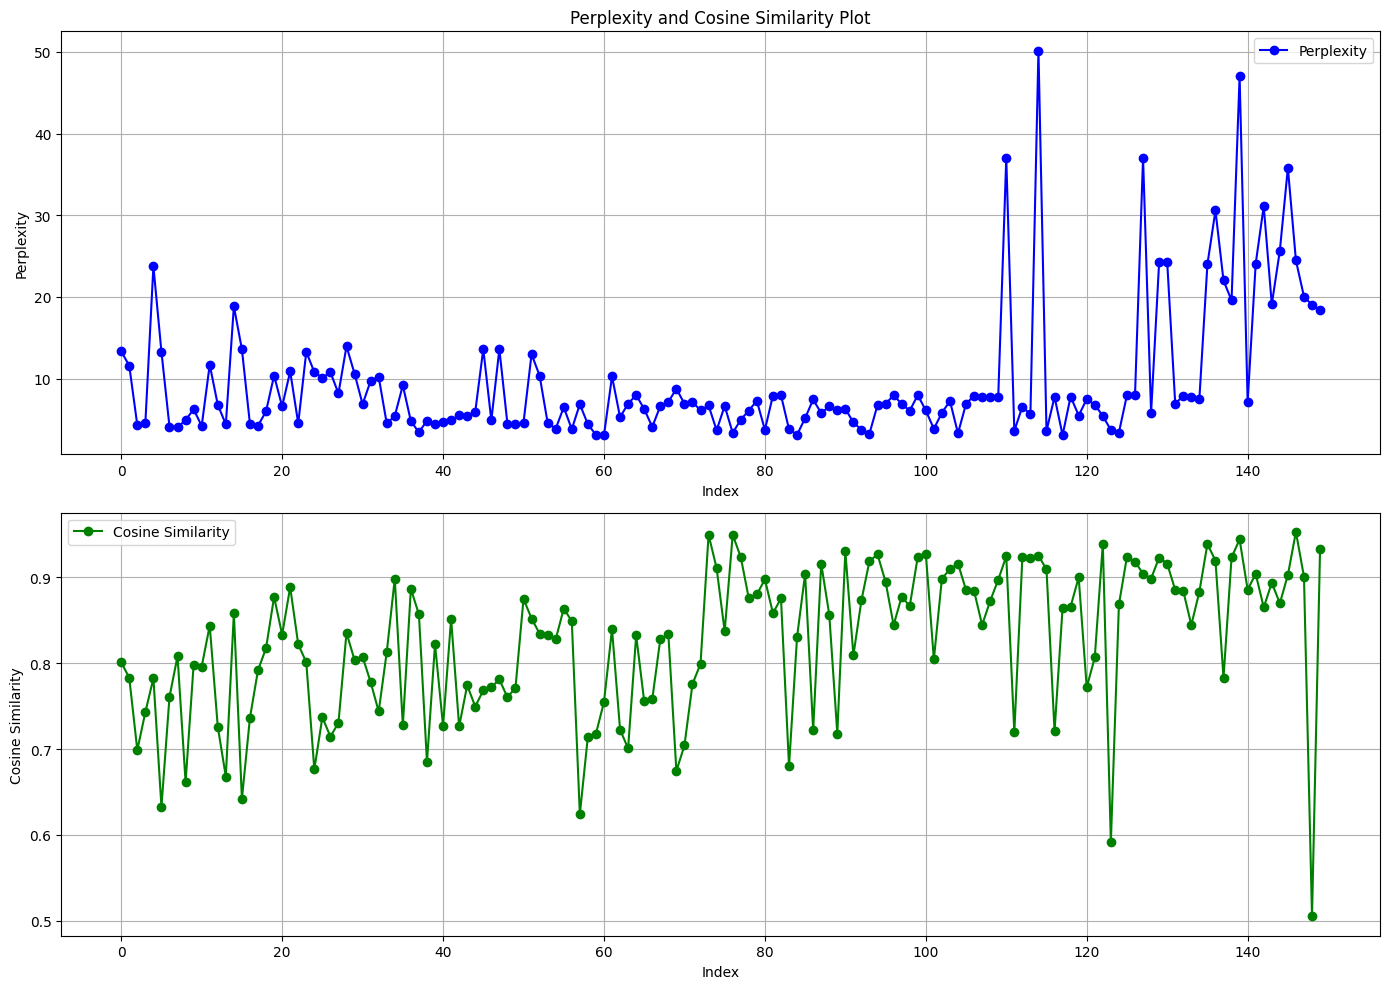

In [80]:
evaluation_csv_path = '/kaggle/input/test-result/updated_Llama_results.csv'
data = pd.read_csv(evaluation_csv_path)
data['Perplexity'] = data['Perplexity'].apply(lambda x: float(x.strip("[]")))
data['Cosine Similarity'] = data['Cosine Similarity'].apply(lambda x: float(x.strip("[]")))
average_perplexity = data['Perplexity'].mean()
average_cosine_similarity = data['Cosine Similarity'].mean()

print(f"Average Perplexity: {average_perplexity:.2f}")
print(f"Average Cosine Similarity: {average_cosine_similarity:.2f}")
plt.figure(figsize=(14, 10))

# Perplexity plot
plt.subplot(2, 1, 1)
plt.plot(data['Perplexity'], marker='o', linestyle='-', color='b', label='Perplexity')
plt.title("Perplexity and Cosine Similarity Plot")
plt.xlabel("Index")
plt.ylabel("Perplexity")
plt.legend()
plt.grid(True)

# Cosine Similarity plot
plt.subplot(2, 1, 2)
plt.plot(data['Cosine Similarity'], marker='o', linestyle='-', color='g', label='Cosine Similarity')
plt.xlabel("Index")
plt.ylabel("Cosine Similarity")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
